Comp 47350 - Assignment 2  
Tania Lopes *(22202398)*  
Emma Cassar Torreggiani *(18389156)*

# **Introduction**

Over the course of the pandemic, the CDC colected data about Covid-19, analyzing cases, deaths, and trends throughout the United States. In Homework 1, a Data Quality Report and Data Quality Plan were prepared to remedy issues in logical integrity and incompleteness of the dataset. Please refer to the accompanying <a href="../Reference/Homework1-Notebook.ipynb"> Homework 1 Notebook </a> and <a href="../Reference/Data Quality Report.pdf">Data Quality Report</a> for the steps taken to date to prepare the data for modeling in addition to some key terminology to be familiar with.   
$~$  
The dataset will be used to inform a series of prediction models, where the target feature is ‘death_yn’, indicative of whether or not the patient died as a result of the virus, and coded as ‘yes’ or ‘no’. The three prediction models being implemented and evaluated are a Linear Regression Model, a Logistic Regression Model, and a Random Forest Model. The following notebook outlines the steps taken to further prepare the data for prediction, implementation and analysis of the three models, and a conclusion where we discuss potential optimizations and improvements.

This notebook will be split into 5 main parts.   
- [1.0 Data Understanding and Preparation](#10-data-understanding-and-preparation)
- [2.0 Predictive Modeling - Linear Regression](#20-predictive-modeling-linear-regression)
- [3.0 Predictive Modeling - Logical Regression](#30-predictive-modeling-logistic-regression)
- [4.0 Predictive Modeling - Random Forest](#40-predictive-modeling-random-forest)
- [5.0 Optimizations & Conclusion](#50-optimizations--conclusion)

# **1.0 Data Understanding and Preparation** 

## 1.1 Prepare environment and load data
First things first, we need to import the packages that will help us with our data analysis.

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source
from IPython.display import Image, display

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
from tabulate import tabulate
import pydotplus

### Define some functions that will help us throughout to analyze the data and regressions

In [265]:
def calculateNthMode(dataFrame, n):
    describeData = dataFrame.describe(datetime_is_numeric = True).T

    indices = describeData.index.values.tolist()

    secondMode = []
    secondModeFreq = []
    
    for column in dataFrame:
        secondMode.append(dataFrame[column].value_counts().index.tolist()[n-1])
        secondModeFreq.append(dataFrame[column].value_counts().tolist()[n-1])

    second_mode = pd.DataFrame(secondMode, columns=[f'{n}th mode']).set_index([indices]).T
    second_mode_freq = pd.DataFrame(secondModeFreq, columns=[f'{n}th mode freq']).set_index([indices]).T

    return second_mode, second_mode_freq


def applyToRowsAndAppend(dataFrame, expression, columnName):
    tempDataFrame_result = dataFrame.apply(expression, axis=1).rename(columnName)
    tempDataFrame = pd.concat([dataFrame, tempDataFrame_result], axis=1)
    return tempDataFrame


def getDescriptiveStatisticsForContinuousFeatures(dataFrame):
    # Get descriptive statistics, mode, second mode, and cardinality
    stats = dataFrame.describe(datetime_is_numeric = True)

    n_missing = pd.DataFrame((dataFrame.isnull()).sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame.isnull()).sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    first_mode, first_modeFreq = calculateNthMode(dataFrame, 1)
    second_mode, second_modeFreq = calculateNthMode(dataFrame, 2)
    cardinality = pd.DataFrame(dataFrame.nunique(), columns=['cardinality']).T

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, first_mode, first_modeFreq, second_mode, second_modeFreq, cardinality]).T

    return stats


def getDescriptiveStatisticsForCategoricalFeatures(dataFrame):
    # Calculate the number of missing entries for each of the continuous feature
    stats = dataFrame.describe()

    n_missing = pd.DataFrame((dataFrame == 'Missing').sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame == 'Missing').sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    # Calculate second mode
    second_mode, second_mode_frequency = calculateNthMode(dataFrame, 2)

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, second_mode, second_mode_frequency]).T

    return stats


def getValidityColumn(dataFrame, expression):
    validity_result = applyToRowsAndAppend(dataFrame, expression, 'Validity')
    
    # Count the number of columns where validity is not equal to True
    invalid_entry = validity_result['Validity'].value_counts().index.tolist()

    if len(invalid_entry) == 1 and invalid_entry[0]:
        print("The data passes the test.")
    else:
        count_invalid_entry = len(validity_result.loc[validity_result['Validity'] == False])
        print(f"The data does not pass the test. \n{count_invalid_entry} invalid entries.")

def getCorrelations(data, columns, abs_corr=False):
    correlation = data[columns].corr(numeric_only=False)
    if (abs_corr):
        correlation = abs(correlation)
    return correlation

def plotCorrelationHeatmap(data, columns, ax=None, abs_corr=False):
    # Print the correlation between the continuous data types
    # Specify numeric_only as False to allow us to include correlation with case_month
    correlation = getCorrelations(data, columns, abs_corr)

    # Generate a mask for the upper triangle
    corr_mask = np.zeros_like(correlation, dtype=np.bool_)
    corr_mask[np.triu_indices_from(corr_mask)] = True

    # Generate a custom colormap - cyan and red
    corr_cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Use the provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, annot=True, mask=corr_mask, cmap=corr_cmap, vmax=1, vmin=-1,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    
    # Set the title of the plot
    ax.set_title('Correlation Heatmap')
    
    # Show the plot if no ax was provided
    if ax is None:
        plt.show()

def plotCrosstabHeatmap(data, column1, column2, ax=None):
    # Create a cross-tabulation of two categorical variables
    crosstab = pd.crosstab(data[column1], data[column2], normalize=True)

    # Generate a custom colormap - cyan and red
    crosstab_cmap = sns.light_palette((10/360 ,75/100,50/100), input="hls", as_cmap=True)
    # crosstab_cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Use the provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    
    # Create a heatmap of the cross-tabulation
    sns.heatmap(crosstab, annot=False, cmap=crosstab_cmap,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


def createStackedHistograms(data, group, to_count, bin_count=10, ax=None, i=None, j=None, filterExp=None, labelheights=None, ylim = 1):
    
    # group the data by the specified column
    data = data.dropna().copy()
    if filterExp != None:
        data = data.loc[data.apply(filterExp, axis=1)]
    if data[to_count].dtype == 'datetime64[ns]':
        data.loc[:, to_count] = (data[to_count].apply(lambda x: (x.year - data[to_count].min().year) * 12 + x.month))
    
    grouped_data = data.groupby(group)[to_count]

    values = data[to_count]
    bin_range = np.linspace(values.min(), values.max(), bin_count + 1)
    bin_width = bin_range[1]-bin_range[0]

    # Create a list of zeros to be the bottom value of each histogram bar
    bottom = 0
    bottom_value = [bottom for i in range(bin_count)]
    # Create a list of ones to be the bottom value of each histogram bar
    top = ylim
    top_value = [top for i in range(bin_count)]
    # Create a list of zeros to be a placeholder for number of bars too small to show text
    too_small_count = [0 for i in range(bin_count)]

    for name, group_data in grouped_data:
        # Get counts for histogram
        hist, _ = np.histogram(group_data, bins=bin_range)
        pct = hist / len(group_data) if len(group_data) != 0 else 0

        # Draw the histogram for the first group
        ax.bar(bin_range[:-1], pct, label=name, align='edge', width=bin_width,
               bottom=bottom_value, edgecolor='black', linewidth=0.5)
        ax.set_ylim(top=1)
        if labelheights == None:
            labelheights = (len(grouped_data) * 0.025,
                            len(grouped_data) * 0.025)

        # Count the values that will be too small to display in the center of the bar
        threshold = labelheights[0]
        if not isinstance(pct, np.ndarray):
            increment = 1 if 0 < pct < threshold else 0
            too_small_count = [tsc + increment for tsc in too_small_count]
            bottom_value = [bv + pct for bv in bottom_value]
        else:
            increment = list(map(lambda h: 1 if 0 < h < threshold else 0, pct))
            too_small_count = [tsc + i for tsc, i in zip(too_small_count, increment)]
            bottom_value += pct

        def createlabel(val):
            x = bin_range[i]+bin_width/2
            y = bottom_value[i]-val/2 + (too_small_count[i])*labelheights[1]
            text_name = textwrap.shorten(str(name).replace("/", " / ").replace("-"," - "), width=13, placeholder="...")
            val_text = int(round(val, 2)*100)
            ax.text(
                x=x, y=y, fontsize=6,
                s=f"{text_name}:\n {val_text}%",
                ha='center', va='center', zorder=4
            )

            rect = plt.Rectangle((x-bin_width*.9/2, y-(labelheights[1]*.8)/2),
                             width=bin_width*0.9, height=labelheights[1]*.8,
                             zorder=3, alpha=0.5, facecolor="white",
                             linewidth=0.5, edgecolor='black')
            ax.add_patch(rect)


        # Create text labels for each bar
        if not isinstance(pct, np.ndarray):
            val = pct
            if val != 0:
                createlabel(val)

        else:
            for i, val in enumerate(pct):
                if val != 0:
                    createlabel(val)
        
        ax.set_xticks(bin_range)
        ax.grid(axis='y', alpha=0.5, color='lightgrey', linestyle='--')
        ax.set_yticks(np.linspace(bottom, top, 11))


        # Axis labels
        ax.set_xlabel(str(to_count).title().replace("_", " "), labelpad=20)
        ax.set_ylabel(f'Frequency of {group.replace("_", " ").title()}', labelpad=20)

        title = f'{to_count} by {group}'.replace("_", " ").title()
        ax.set_title(title, fontsize=18, pad=20)
        ax.legend()


def getUniqueValueCounts(data):
    x, y = data.columns
    unique_values = data[y].unique().tolist()
    new_data = pd.DataFrame()

    for val in unique_values:
        # Select only the rows that match the criteria for this row.
        data_vc = data.loc[lambda row: row[y] == val][x].value_counts()
        # Get the distribution of values in column_y for each unique_value from column_x
        data_counts = list(map(lambda count: round(
            count / sum(data_vc), 2), data_vc.tolist()))
        data_values = data_vc.index.tolist()
        # Generate a new row entry to be inserted into the table for this category
        data_vc = pd.DataFrame(data_counts, data_values, columns=[val]).T

        # Add the row to the table for this graph
        new_data = pd.concat([new_data, data_vc])
    return new_data

def createStackedBarChart(data, column_x, column_y, axs=None, i=None, j=None):
    stacked_bar = data[[column_x, column_y]]

    stacked_bars = getUniqueValueCounts(stacked_bar)

    # Create plots
    if type(axs) == 'NoneType' and (i == None and j == None):
        plot = stacked_bars.plot.bar(stacked=True, edgecolor='#111111')
    elif type(axs) != 'NoneType' and (i == None and j == None):
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs,  edgecolor='#111111')
    elif type(axs) != 'NoneType' and (i == None and j != None):
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs[j], edgecolor='#111111')
    else:
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs[i][j], edgecolor='#111111')

    # Label parameters
    label_text = []
    for label in plot.get_xticklabels():
        lt = label.get_text().replace("/", " / ")
        label_text.append("\n".join(textwrap.wrap(lt, width=20)))
    plot.set_xticklabels(label_text)
    plot.tick_params(labelsize=8, rotation=45)

    # Bar labels
    for cont in plot.containers:
        plot.bar_label(cont, fontsize=8, label_type='center')

    # Axis labels
    plot.set_xlabel(str(column_y).title().replace("_", " "))
    plot.set_ylabel("Frequency")

    # Split title text
    title = "\n".join(textwrap.wrap(
        (f"Frequency of {column_x} by {column_y}").upper().replace("_", " "), 20))
    plot.set_title(title, fontsize=24, pad=20, wrap=True)

    # Legend and grid
    plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot.grid(visible=True, which='minor',
              color='#999999', linestyle='-', alpha=0.2)
    plot.grid(visible=True, which='major', color='#666666', linestyle='-')

    # Subplot spacing
    plt.subplots_adjust(left=0.1,  # The position of the left edge of the subplots, as a fraction of the figure width.
                        # bottom=0.1, # The position of the bottom edge of the subplots, as a fraction of the figure height.
                        # The position of the right edge of the subplots, as a fraction of the figure width.
                        right=1.5,
                        # top=0.9,    # The position of the top edge of the subplots, as a fraction of the figure height.
                        # The width of the padding between subplots, as a fraction of the average Axes width.
                        wspace=1.5,
                        # The height of the padding between subplots, as a fraction of the average Axes height.
                        hspace=0.75
                        )


### 1.1.1 Merging the datasets

The original data sets from the CDC have been cleaned as part of Task 1. Each student had a different body of work for the this task, and one was selected as a starting point for this work. The cleaning steps have been applied to two data sets, and both 'covid19-cdc-22202398_final' and 'covid19-cdc-18389156_final.csv' will need to be loaded and combined for the modeling to begin.

The Data Quality Report from the first assignment can be found in the accompanying pdf. The Data Quality Plan is included below.  

| Feature Name                      | Data Quality Issue         | Handling Strategy                                                                                               |
|-----------------------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------|
| case_month                        | None                       | Keep as Is                                                                                                      |
| res_state                         | Redundant                  | Drop Feature                                                                                                    |
| state_fips_code                   | Redundant                  | Drop Feature                                                                                                    |
| res_county                        | Redundant and Ambiguous    | Drop Feature                                                                                                    |
| county_fips_code                  | Missing Data               | Impute using state_fips_code values * 1000 to generate new county_fips_codes when missing                       |
| age_group                         | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| sex                               | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| race                              | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| ethnicity                         | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| case_positive_specimen_interval   | Invalid Data               | Take the absolute value of the data to make all values positive                                                 |
| case_positive_specimen_interval   | Not Applicable Data        | Distinguish between 'Missing' values when the number is not applicable, versus when the number was truly not present in the set |
| case_positive_specimen_interval   | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| case_positive_specimen_interval   | Outliers                   | Keep as is for now, after cleaning the data, re-evaluate                                                       |
| case_onset_interval               | Invalid Data               | Take the absolute value of the data to make all values positive                                                 |
| case_onset_interval               | Not Applicable Data        | Distinguish between 'Missing' values when the number is not applicable, versus when the number was truly not present in the set |
| case_onset_interval               | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| case_onset_interval               | Outliers                   | Keep as is for now, after cleaning the data, re-evaluate                                                       |
| process                           | 90%+ Missing               | Drop Feature                                                                                                    |
| exposure_yn                       | 90%+ Missing               | Drop Feature                                                                                                    |
| current_status                    | Illogical Data             | Replace with 'Laboratory-confirmed case' if 'case_positive_specimen_interval' is not Null                     |
| symptom_status                    | Illogical Data             | Replace with 'Yes' if 'hospital_yn' is 'Yes', 'icu_yn' is 'Yes', or 'death_yn' is 'Yes'; Replace with 'Yes' if 'case_onset_interval' is not Null |
| symptom_status                    | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| hosp_yn                           | Illogical Data             | Replace with 'Yes' if 'icu_yn' is 'Yes'                                                                         |
| hosp_yn                           | Missing Data               | Impute using k-nearest neighbor algorithm                                                                        |
| icu_yn                            | 90%+ Missing               | Drop Feature                                                                                                    |
| underlying_conditions_yn          | 90%+ missing               | Drop Feature                                                                                                    |


Additionally, a number of external features from beyond the CDC data set have been included in the dataset:
- Income: the average household income for residents in the patient's county
- People_Vaccinated: the number of Americans who had been vaccinated at the time of the patient's illness
- Risk_Factor: a flag to indicate whether the patient is in one of the groups with more deaths than others in the original dataset (Age 50-64 or 65+, Male, Black, or Hispanic/Latino).
- Month_of_Year: the month in which a patient's illness is reported, irrespective of the year.
- Season: the season in which a patient's illness is reported.
More information on these features can be found in the notebook for Assignment 1.

Finally, the data from the previous assignment is imported below, with two files, one for each student. We use pandas to concatenate the two sets into one large dat set.

In [266]:
data_student_01 = pd.read_csv('data\covid19-cdc-22202398_final_assignment2.csv', keep_default_na=True)
data_student_02 = pd.read_csv('data\covid19-cdc-18389156_final_assignment2.csv', keep_default_na=True)

data = pd.concat([data_student_01, data_student_02], axis=0)

data.head(5)

,case_month,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,current_status,symptom_status,hosp_yn,death_yn,income,people_vaccinated,risk_factor,month_of_year,season
0,2020-11-01,32003,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,59340,0,1,11,Autumn
1,2021-08-01,4013,50 to 64 years,Male,White,Hispanic/Latino,3.0,0.0,Laboratory-confirmed case,Symptomatic,No,Yes,64468,206797098,1,8,Summer
2,2020-12-01,12101,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,52828,5566951,1,12,Winter
3,2020-12-01,6037,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,68044,5566951,1,12,Winter
4,2020-11-01,48029,65+ years,Male,White,Hispanic/Latino,0.0,6.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,57157,0,1,11,Autumn


To recap what has already been done, we will check the shape of the set, inspect the datatypes and check if there are any remaining invalid null values.

In [267]:
rows, columns = data.shape
print(f"The data set has {rows} rows and {columns} columns.")

The data set has 37940 rows and 17 columns.


### 1.1.2 Assigning DataTypes

In [268]:
data.dtypes

case_month                          object
county_fips_code                     int64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
current_status                      object
symptom_status                      object
hosp_yn                             object
death_yn                            object
income                               int64
people_vaccinated                    int64
risk_factor                          int64
month_of_year                        int64
season                              object
dtype: object

The data types we have assigned in the data cleaning step were not preserved when the file was converted to a .csv. As such, we will need to reintroduce them before starting to work with the data. First we will assign ints and datetime types to the relevant features.

In [269]:
# Get continuous date features and int features separately
continuous_date = ['case_month']
continuous_int = ['case_positive_specimen_interval', 'case_onset_interval', 'income', 'people_vaccinated', 'month_of_year']

# Get aggregated continuous features
continuous = continuous_date + continuous_int

# Assign types to columns - dates
for column in continuous_date:
    data[column] = data[column].astype('datetime64[ns]')

# Assign types to columns - integers
for column in continuous_int:
    data[column] = data[column].astype('Int64')

# Print data types
data.dtypes

case_month                         datetime64[ns]
county_fips_code                            int64
age_group                                  object
sex                                        object
race                                       object
ethnicity                                  object
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
current_status                             object
symptom_status                             object
hosp_yn                                    object
death_yn                                   object
income                                      Int64
people_vaccinated                           Int64
risk_factor                                 int64
month_of_year                               Int64
season                                     object
dtype: object

Next, we will assign data types to the categorical features. We will separate these features into two categories: boolean and category.  
$~$  
**Boolean Features**
- current_status: True for Laboratory Confirmed Case, False for Probably Case
- symptom_status: True for Symptomatic, False for Asymptomatic
- hosp_yn: True for Hospitalized, False for Not
- risk_factor: True for 1, False for 0
- detah_yn: True for y, False for n  

**Category Features**  
- county_fips_code (*this feature is perhaps too granular, so we will replace it with state fips code*)
- age_group
- sex
- race
- ethnicity
- season

In [270]:
# Get categorical features
categorical_category = ['county_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'season']
categorical_bool = ['current_status', 'symptom_status', 'hosp_yn', 'risk_factor', 'death_yn']
categorical =  categorical_category + categorical_bool

# Assign types to columns - boolean
for column in categorical_bool:
    if column == 'current_status':
        data[column] = data[column].map({'Laboratory-confirmed case': 1, 'Probable Case': 0})
    elif column == 'symptom_status':
        data[column] = data[column].map({'Symptomatic': 1, 'Asymptomatic': 0})
    elif column == 'hosp_yn' or column == 'death_yn':
        data[column] = data[column].map({'Yes': 1, 'No': 0})
    data[column] = data[column].astype('uint8')

# Assign types to columns - categorical
for column in categorical_category:
    data[column] = data[column].astype('category')

# Rename columns to match restructuring of data
data.rename(columns={'current_status': 'laboratory_confirmed_tf', 'symptom_status': 'symptomatic_tf', 'hosp_yn': 'hosp_tf', 'risk_factor': 'risk_factor_tf', 'death_yn': 'death_tf'}, inplace=True)

data.dtypes

case_month                         datetime64[ns]
county_fips_code                         category
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
laboratory_confirmed_tf                     uint8
symptomatic_tf                              uint8
hosp_tf                                     uint8
death_tf                                    uint8
income                                      Int64
people_vaccinated                           Int64
risk_factor_tf                              uint8
month_of_year                               Int64
season                                   category
dtype: object

In [271]:
# Update county_fips_code column, converting county fips codes to state fips codes
data['county_fips_code'] = data['county_fips_code'].apply(lambda row: row // 1000).astype('uint8')
data.rename(columns={'county_fips_code': 'state_fips_code'}, inplace=True)

# Get renamed categorical features
categorical_category = ['state_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'season']
categorical_bool = ['laboratory_confirmed_tf', 'symptomatic_tf', 'hosp_tf', 'risk_factor_tf', 'death_tf']
categorical =  categorical_category + categorical_bool

In [272]:
data.head(100)

,case_month,state_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,laboratory_confirmed_tf,symptomatic_tf,hosp_tf,death_tf,income,people_vaccinated,risk_factor_tf,month_of_year,season
0,2020-11-01,32,65+ years,Female,White,Non-Hispanic/Latino,2,0,1,1,1,1,59340,0,1,11,Autumn
1,2021-08-01,4,50 to 64 years,Male,White,Hispanic/Latino,3,0,1,1,0,1,64468,206797098,1,8,Summer
2,2020-12-01,12,65+ years,Male,White,Non-Hispanic/Latino,0,0,1,1,1,1,52828,5566951,1,12,Winter
3,2020-12-01,6,65+ years,Female,White,Non-Hispanic/Latino,2,0,1,1,1,1,68044,5566951,1,12,Winter
4,2020-11-01,48,65+ years,Male,White,Hispanic/Latino,0,6,1,1,1,1,57157,0,1,11,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-04-01,36,65+ years,Female,White,Hispanic/Latino,0,0,1,1,1,1,40088,0,1,4,Spring
96,2020-06-01,6,50 to 64 years,Female,White,Hispanic/Latino,2,0,1,1,1,1,68044,0,1,6,Summer
97,2020-04-01,36,65+ years,Male,White,Non-Hispanic/Latino,0,0,1,1,1,1,60231,0,1,4,Spring
98,2021-12-01,72,65+ years,Male,Multiple/Other,Hispanic/Latino,0,0,1,1,1,1,51347,244166911,1,12,Winter


In [273]:
data.dtypes

case_month                         datetime64[ns]
state_fips_code                             uint8
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
laboratory_confirmed_tf                     uint8
symptomatic_tf                              uint8
hosp_tf                                     uint8
death_tf                                    uint8
income                                      Int64
people_vaccinated                           Int64
risk_factor_tf                              uint8
month_of_year                               Int64
season                                   category
dtype: object

### 1.1.3 Checking Null Values

In [274]:
data.isna().sum()

case_month                            0
state_fips_code                       0
age_group                             0
sex                                   0
race                                  0
ethnicity                             0
case_positive_specimen_interval    2490
case_onset_interval                 550
laboratory_confirmed_tf               0
symptomatic_tf                        0
hosp_tf                               0
death_tf                              0
income                                0
people_vaccinated                     0
risk_factor_tf                        0
month_of_year                         0
season                                0
dtype: int64

As expected, the 'case_positive_specimen_interval' and 'case_onset_interval' features contain null values, which are logical considering the nature of the data. To incorporate these features in the regression models, we have several options for handling the null values.

We can immediately eliminate the option of dropping the features due to the small percentage of null values. To address the null values in each column, we will instead consider two approaches: imputation with representative values and replacement with a distinct value. 
1. **Imputation**: We will explore three strategies - imputing with the median, mean, and mode values of the non-null data.
2. **Replacement**: We will also consider replacing the null values with a distinct value that significantly exceeds the range of actual values, such as -1 or 999.
To determine the best approach, we will assess the correlation of each imputation method and the replacement approach with the target feature. By considering their impact on the target feature, we can make an informed decision on how to handle the null values in the two columns.

#### Case Positive Specimen Interval
We will first implement the two approaches for the case_positive_specimen_interval.

In [275]:
# Address null values for case_positive_specimen_interval
data_case_pos_spec_na= data.copy()

# Option 1.1: Impute with median
data_case_pos_spec_na['case_pos_spec_median'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].median()).astype('int64')
# Option 1.2: Impute with mean
data_case_pos_spec_na['case_pos_spec_mean'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].mean().round()).astype('int64')
# Option 1.1: Impute with mode
data_case_pos_spec_na['case_pos_spec_mode'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].mode().values[0]).astype('int64')

# Option 2: Impute with strange value 999
data_case_pos_spec_na['case_pos_spec_odd_value'] = data['case_positive_specimen_interval'].fillna(999).astype('int64')

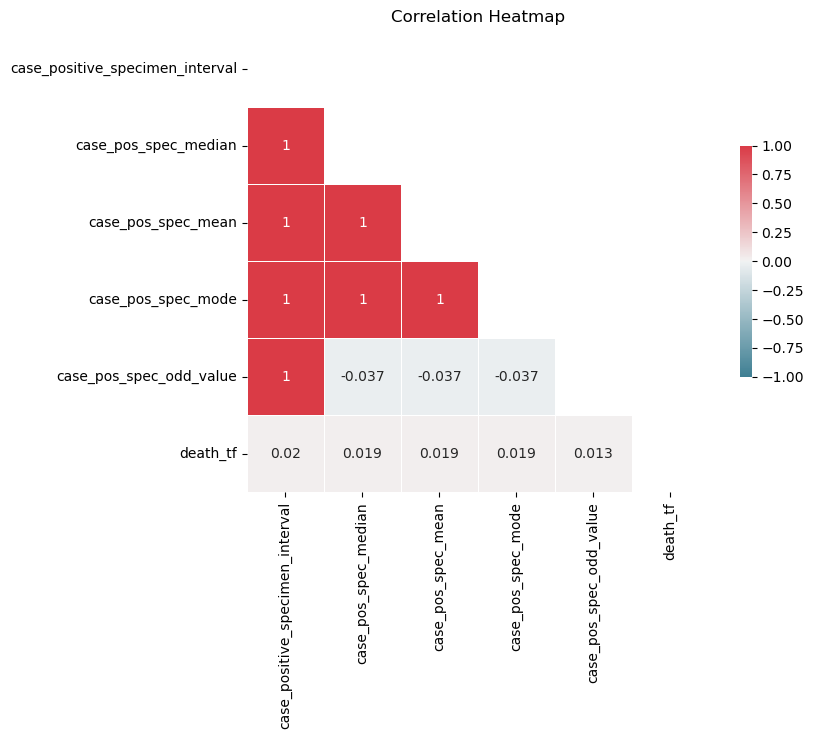

In [276]:
plotCorrelationHeatmap(data_case_pos_spec_na, ['case_positive_specimen_interval', 'case_pos_spec_median', 'case_pos_spec_mean', 'case_pos_spec_mode', 'case_pos_spec_odd_value', 'death_tf'])

Reviewing the correlations above, it is evident that the differences in the correlations with the target feature are minimal. The variations observed between the original column with null values and the columns where imputation was performed are very slight, with none of the differences exceeding 0.007. 

|Replacement Column|correlation with death_tf|difference in correlation|
|:----|:----|:----|
|case_positive_specimen_interval|0.02|-|
|case_pos_spec_median|0.019|0.001|
|case_pos_spec_mean|0.019|0.001|
|case_pos_spec_mode|0.019|0.001|
|case_pos_spec_odd_value|0.013|0.007|

We conclude that the imputation process had a negligible impact on the correlations between the features and the target variable. We will choose the option that is closest to the original and drop the original column. In this case mean, median, and mode all present with the same correlation and we will arbitrarily choose to use the mode.

In [277]:
data_cleaned = data.copy()
data_cleaned['case_positive_specimen_interval'] = data_case_pos_spec_na['case_pos_spec_mode']

#### Case Onset Interval
We will perform the same steps for the 'case_onset_interval' feature.

In [278]:
# Address null values for case_positive_specimen_interval
data_case_onset_na= data.copy()

# Option 1.1: Impute with median
data_case_onset_na['case_onset_median'] = data['case_onset_interval'].fillna(data['case_onset_interval'].median()).astype('int64')
# Option 1.2: Impute with mean
data_case_onset_na['case_onset_mean'] = data['case_onset_interval'].fillna(data['case_onset_interval'].mean().round()).astype('int64')
# Option 1.1: Impute with mode
data_case_onset_na['case_onset_mode'] = data['case_onset_interval'].fillna(data['case_onset_interval'].mode().values[0]).astype('int64')

# Option 2: Impute with strange value 999
data_case_onset_na['case_onset_odd_value'] = data['case_onset_interval'].fillna(999).astype('Int64')

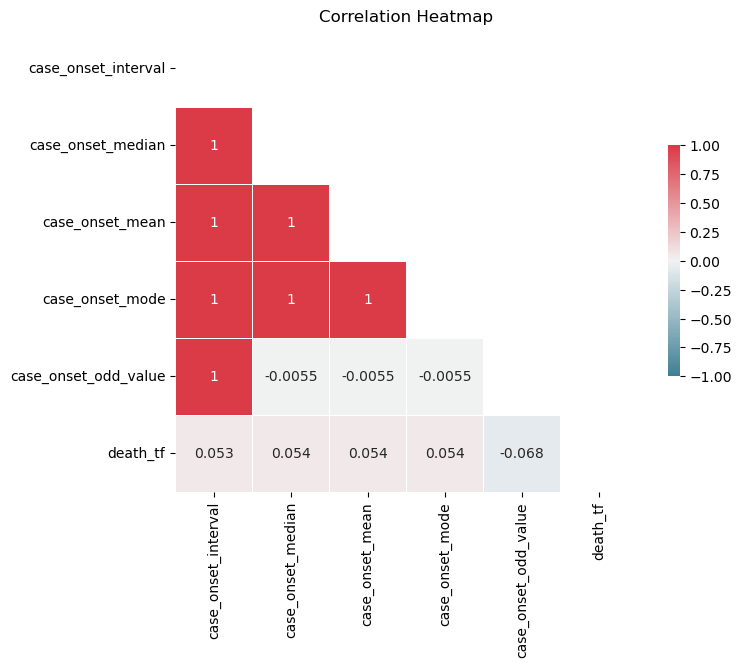

In [279]:
plotCorrelationHeatmap(data_case_onset_na, ['case_onset_interval', 'case_onset_median', 'case_onset_mean', 'case_onset_mode', 'case_onset_odd_value', 'death_tf'])

Once again, the differences in the correlations with the target feature are minimal. With the exception of the case_onset_odd_value, none of the differences exceeds 0.001. 

|Replacement Column|correlation with death_tf|difference in correlation|
|:----|:----|:----|
|case_onset_interval|0.053|-|
|case_onset_median|0.054|-0.001|
|case_onset_mean|0.054|-0.001|
|case_onset_mode|0.054|-0.001|
|case_onset_odd_value|-0.068|0.121|

We conclude that the imputation process had a negligible impact on the correlations between the features and the target variable. Again mean, median, and mode are equally correlated with the target feature, and we choose to use the mode for consistency. We can now drop the original column.

In [280]:
data_cleaned['case_onset_interval'] = data_case_onset_na['case_onset_mode']

After making these changes, we can verify that null values are no longer present in the set and proceed to splitting the data for training and testing.

In [281]:
data_cleaned.isna().sum()

case_month                         0
state_fips_code                    0
age_group                          0
sex                                0
race                               0
ethnicity                          0
case_positive_specimen_interval    0
case_onset_interval                0
laboratory_confirmed_tf            0
symptomatic_tf                     0
hosp_tf                            0
death_tf                           0
income                             0
people_vaccinated                  0
risk_factor_tf                     0
month_of_year                      0
season                             0
dtype: int64

Now that there are no null values, we will convert all of the continuous columns from Int64 (nullable int64) to int64 (non-nullable int64)

In [282]:
# Assign types to columns - integers
for column in continuous_int:
    data_cleaned[column] = data_cleaned[column].astype('int64')

## 1.2 Splitting the data into two data sets

We can now split the data into two datasets. We have elected not to shuffle the data set because sklearn's split function will shuffle it before splitting. **70%** of the data will be used for training and **30%** will be use for testing.

We will set the random_state variable to 0, to allow the random shuffle to be repeated within this notebook.

In [283]:
from sklearn.model_selection import train_test_split

# Load the dataset into a pandas dataframe and set X and y
X = data_cleaned[['case_month', 'state_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval', 'case_onset_interval', 'laboratory_confirmed_tf', 'symptomatic_tf', 'hosp_tf', 'income', 'people_vaccinated', 'risk_factor_tf', 'month_of_year', 'season']]
y = data_cleaned['death_tf']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Concatenate the X and y training variables into a table.
data_training = pd.concat([X_train, y_train], axis=1)

# Concatenate the X and y testing variables into a table.
data_testing = pd.concat([X_test, y_test], axis=1)

To be as transparent as possible when we split the data, we print the range of rows in the original table, the training table, and the testing table.

In [284]:
print("original range is:\t rows 0 to", data_cleaned.shape[0])
print("training range (70%):\t rows 0 to", round(data_training.shape[0]))
print("test range (30%): \t rows", round(data_training.shape[0]), "to", round(data_training.shape[0]) + data_testing.shape[0])

original range is:	 rows 0 to 37940
training range (70%):	 rows 0 to 26558
test range (30%): 	 rows 26558 to 37940


## 1.3 Start working with the training set

To get a better understanding of the data we are working with, we will analyze the features in our dataset. We will achieve this by analyzing relationships between both continuous and categorical features, both among themselves and with the target feature.

***
### 1.3.1 Continuous Features
***
#### **1.3.1.1 Continuous - Continuous Plots**

First we plot and examine the correlations between continuous features.

In [285]:
# Add the target feature to the list of continuous columns
continuous_corr_features = continuous + ['death_tf']

# Print the correlation between the continuous data types
getCorrelations(data_training, continuous_corr_features, abs_corr=True)

,case_month,case_positive_specimen_interval,case_onset_interval,income,people_vaccinated,month_of_year,death_tf
case_month,1.000000,0.036916,0.041621,0.024631,0.941561,0.066577,0.290332
case_positive_specimen_interval,0.036916,1.000000,0.001640,0.028783,0.031808,0.008764,0.018429
case_onset_interval,0.041621,0.001640,1.000000,0.021305,0.047824,0.013975,0.058749
income,0.024631,0.028783,0.021305,1.000000,0.018872,0.044784,0.040278
people_vaccinated,0.941561,0.031808,0.047824,0.018872,1.000000,0.135669,0.262235
month_of_year,0.066577,0.008764,0.013975,0.044784,0.135669,1.000000,0.011918
death_tf,0.290332,0.018429,0.058749,0.040278,0.262235,0.011918,1.000000


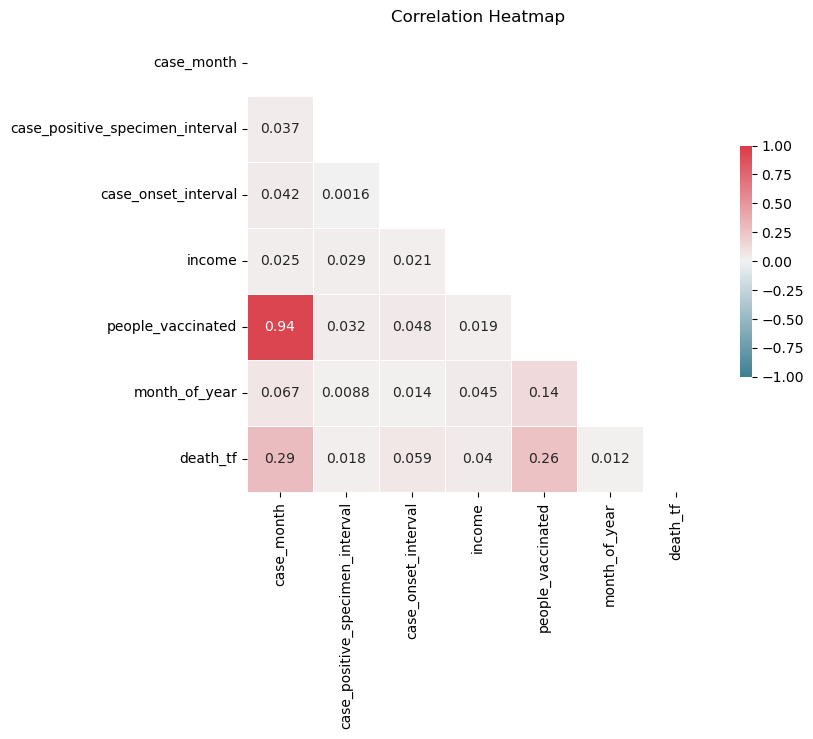

In [286]:
# Print the correlation table
plotCorrelationHeatmap(data_training, continuous_corr_features, abs_corr=True)

##### Interpretation of the results
The plots allow us to visualize pairs of features which correlate strongly to each other. We have arbitrarily identified three types of correlations: low correlation, medium correlation, and high correlation. The boundaries for each bin are arbitrary and used solely for classification purposes.

**Low correlation (x <= 0.02)**
All but 1 pair of features have low correlation. This is to be expected, since it indicates that these features operate independently and do not have a significant impact on each other. Despite their weaker associations, these features still provide unique information that can contribute to the predictive models, offering valuable insights into other factors impacting the target variable.  

**Medium correlation (0.02 < x < 0.10)**  
There quite a few pairs of features with medium correlation. All of the features are at least slightly correlated to case_month and people_vaccinated, while many of the features also seem to have some correlation with income. 

**High correlation (x >= 0.10)**  
Of our few continuous features, there are two pairs with strong correlations. 'people_vaccinated' and 'case_month' have a correlation of 0.94. This is to be expected, since as time passes, more and more people are vaccinated. We can choose to drop one of these features, since they will trend in a similar direction, but as vaccination rates plateau and case months continue to grow, it may be beneficial to keep the two parameters separate. Keeping them distinct allows us to capture the temporal aspect and understand the evolving relationship between vaccinations and cases. The other two are 'people_vaccinated' and 'month_of_year'. This one also makes sense, since they are both linked to the temporal aspect of the progression of the virus.
$~$  

**Features to Remove:** For now, we decide to keep all of the features.

#### **1.3.1.2 Continuous - Target Feature Scatter Plots**
We will create scatter plots to compare each continuous feature with the target feature. This visual analysis will help us identify the features that have a stronger potential to predict the target variable and distinguish them from the less relevant features. By examining these scatter plots, we can isolate a subset of features that appear to be more indicative, allowing us to focus our modeling efforts on the most relevant variables. Features with weaker associations can be eliminated to streamline the model and reduce noise.

,RiskPerformance
case_month,0.290332
people_vaccinated,0.262235
case_onset_interval,0.058749
income,0.040278
case_positive_specimen_interval,0.018429
month_of_year,0.011918


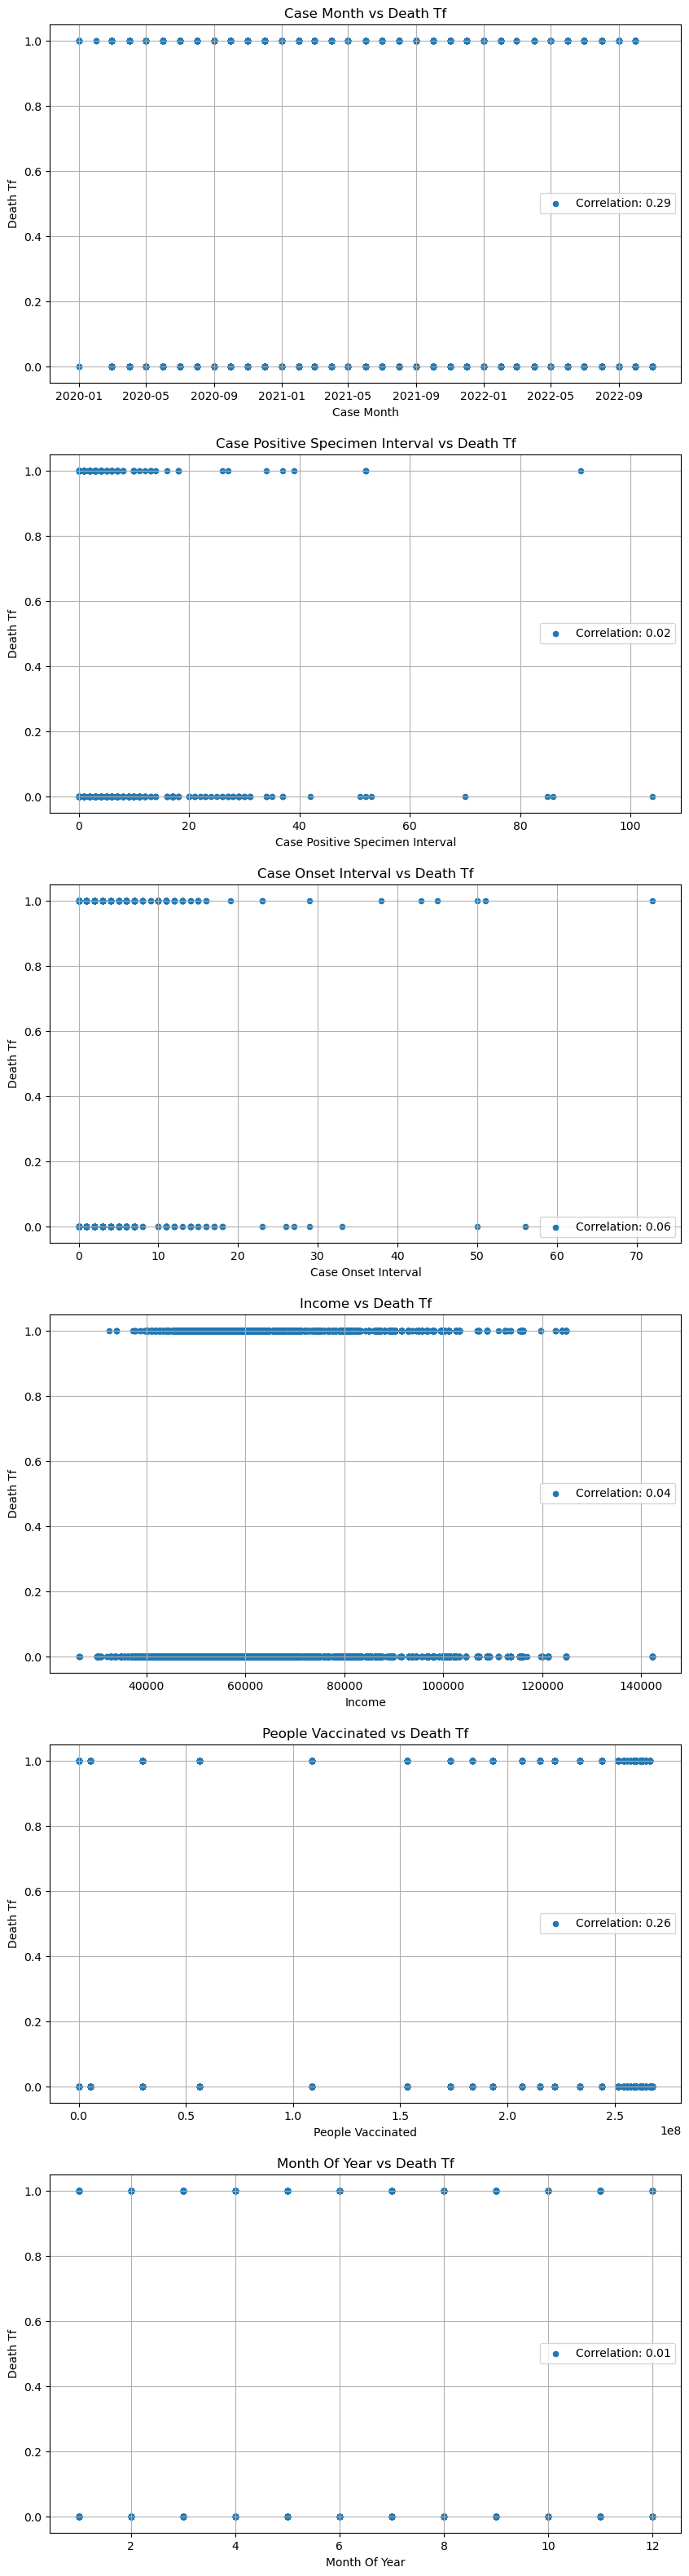

In [287]:
n = len(continuous_corr_features)
fig, axs = plt.subplots(ncols=1, nrows=n-1, figsize=(10,40))

# dict to hold correlation values 
corr_dict = {}

target_feature = 'death_tf'

for i, feature in enumerate(continuous_corr_features):
    if feature != target_feature:
        xlabel = feature.replace("_", " ").title()
        ylabel = target_feature.replace("_", " ").title()

        correlation = data_training[[feature, target_feature]].corr(numeric_only=False).values[0,1]
        title = xlabel + " vs " + ylabel
        values = data_training[[feature, target_feature]]
        scatter = values.plot.scatter(x=feature, y=target_feature, ax=axs[i], grid=True, fontsize=10)
        scatter.legend(["Correlation: {:.2f}".format(abs(correlation))])
        scatter.set_xlabel(xlabel)
        scatter.set_ylabel(ylabel)
        scatter.set_title(title)

        # add correlation to dict
        corr_dict[feature] = abs(correlation)

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['RiskPerformance']).sort_values('RiskPerformance', ascending=False)
corr_df

##### Interpretation of the results
After analyzing the plots, it is evident that there is no single feature that exhibits a very strong correlation with the target feature. This aligns with our understanding of the complexity of predicting survival from COVID-19. The outcome is influenced by a multitude of factors, and no single feature can serve as a definitive indicator of survival.

We again categorized the correlation values into three bins: low correlation, medium correlation, and high correlation. The boundaries for each bin are arbitrary and used solely for classification purposes.


| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.02       | 0.02 < x < 0.10    | x >= 0.10       |
| 2 features    | 2  features        | 2 features       |
| 33%             | 33%                | 33%              | 


**Low correlation (x <= 0.02)**  
There are two features that demonstrate low correlations, but we have decided to retain them for now. Removing these features would result in the elimination of a significant portion of the dataset. We will further consider this decision is in the next step, and evaluate the impact of this decision in Part 5.  

**Medium correlation (0.02 < x < 0.10)**  
There are two features with medium correlation: 'case_onset_interval' and 'month_of_year'

**High correlation (x >= 0.10)**  
The strongest correlations are observed between 'case_month'/'people_vaccinated' and 'death_tf'. This correlation is expected as both features are closely related to the progression of time and the impact of vaccinations. The strong correlations of these features with 'death_tf' align with our expectations, as the duration of the pandemic is likely to capture the complex factors contributing to the severity of the virus.  
  
$~$  
**Features to Remove:** For now, we decide to keep all of the features.

#### **1.3.1.3 Continuous - Target Feature Histograms Plots**
Lastly, we will generate a set of stacked histograms comparing the histograms. While the scatter plots provide insights into the strength of the correlations, the stacked histograms offer a different perspective by illustrating the distribution of deaths across different values of the continuous features. Although the stacked histograms do not directly depict the correlation between the features and the target, they serve a crucial purpose in examining the patterns of deaths within each feature category. This analysis allows us to identify any notable variations or trends in the distribution, which may indicate a potential association between certain feature values and the likelihood of deaths.


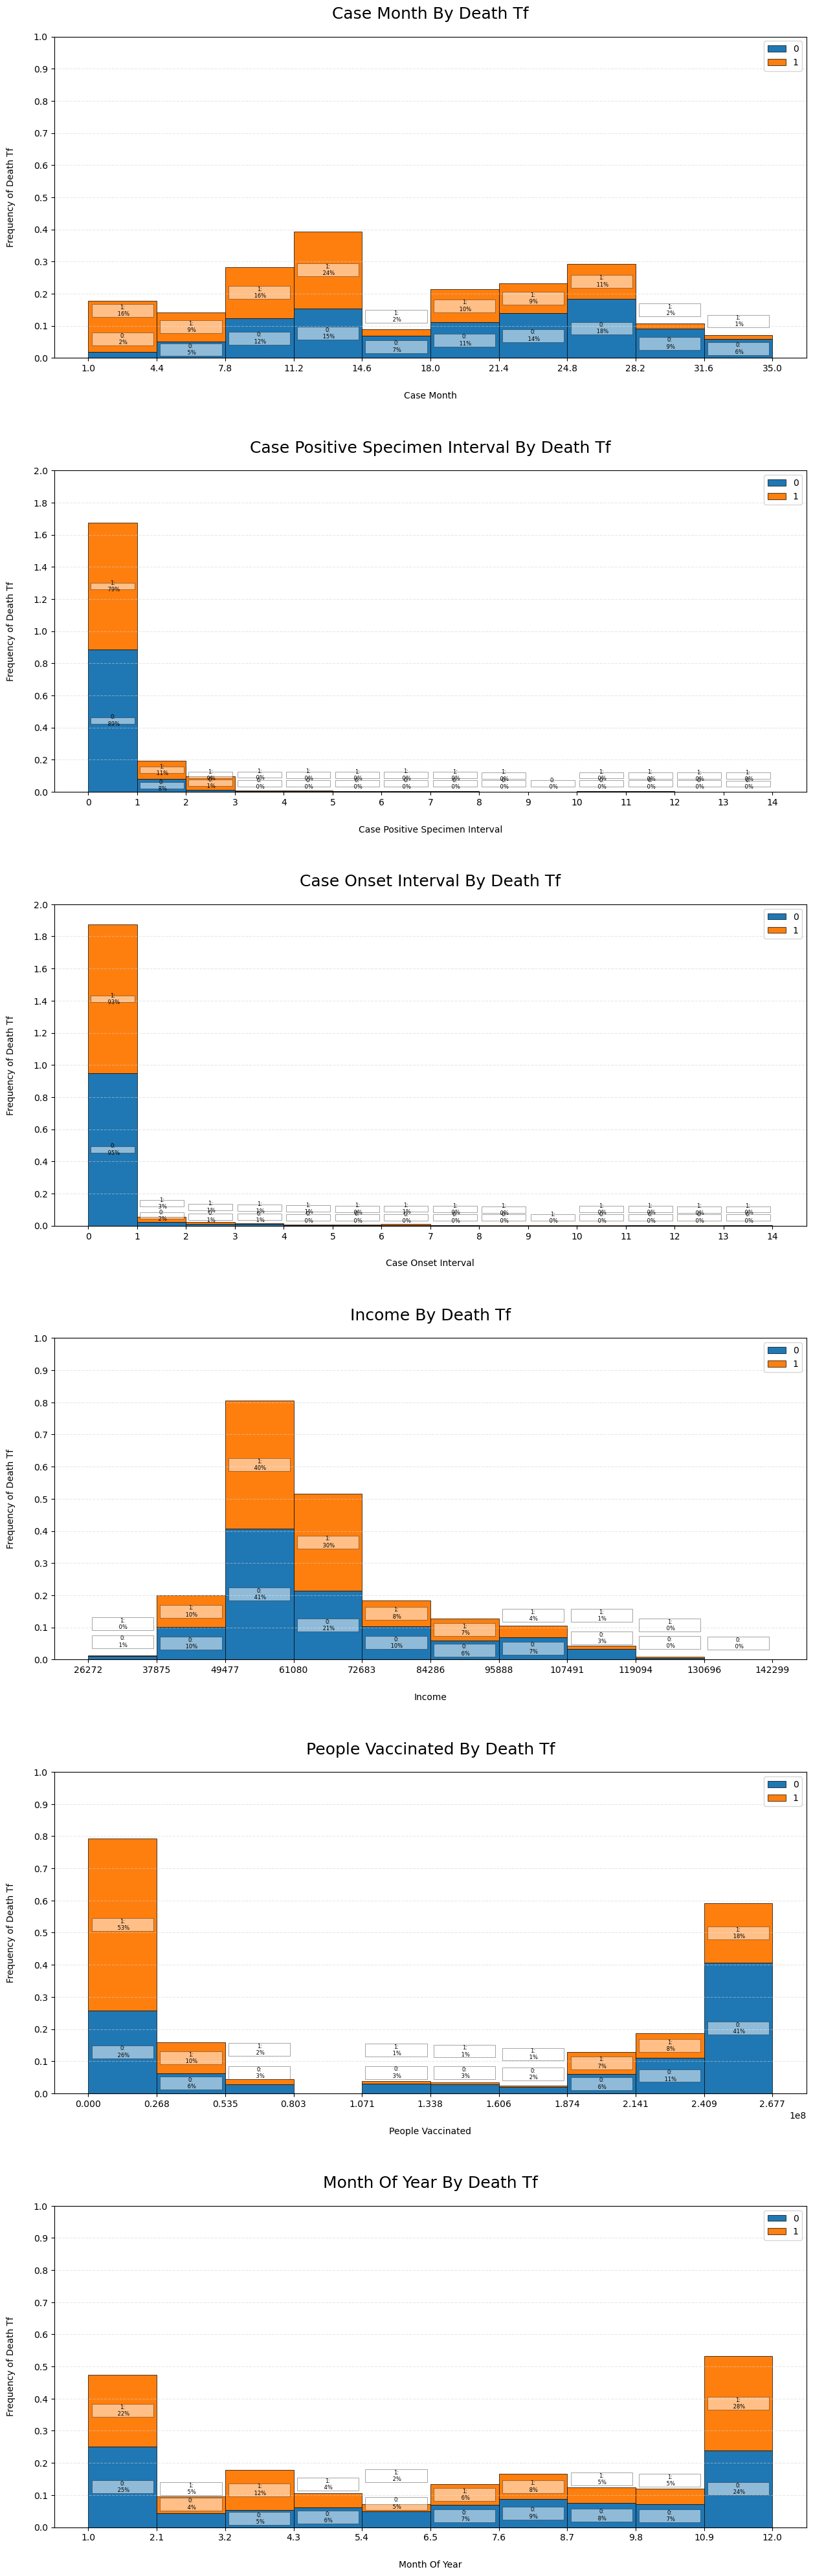

In [288]:
fig, axs = plt.subplots(ncols=1, nrows=6, figsize=(15,50))
fig.subplots_adjust(hspace=0.35)

for i, column in enumerate(continuous):
    if column == 'case_positive_specimen_interval' or column == 'case_onset_interval':
        createStackedHistograms(data_training, 'death_tf', column, bin_count = 14, ax=axs[i], filterExp=lambda row: row[column] <= 14, ylim=2)
    else:
        createStackedHistograms(data_training, 'death_tf', column, bin_count = 10, ax=axs[i])

##### Interpretation of the Results

After analyzing the plots, we have made three more conclusions on the data.

- The 'case_onset_interval' column has an overwhelming majority of values that are 0, and the distribution of deaths (Yes and No) is almost even for each value of this attribute, with the difference within 1%. 

- In contrast, 'case_positive_specimen_interval', despite also having a majority of values as 0, shows a correlation between deaths and its value. When the 'case_positive_specimen_interval' value is 0, the amount of deaths vs survivors is 79% vs 89%. However, for the next two values, the percentages flip, and the amount of deaths vs survivors is 11% vs 8%, and 9% vs 1%.

- 'income', although exhibiting a slight correlation with death, provides a diverse distribution of data, which may lead to interesting results.

- 'month_of_year', although barely exhibiting a correlation with death, has an interesting correlation with the total number of cases.

**Features to Remove:** We decide to remove 'case_onset_interval'.


#### **1.3.1.4 Selection of Indicative Continuous Features**
The set of indicative continuous features we will be using includes the following:
* case_positive_specimen_interval
* income
* case_month
* people_vaccinated
* month_of_year

Based on the histogram analysis and correlation statistics, we've decided to exclude 'case_onset_interval' due to its overwhelming majority of zero values and the even distribution of deaths for each value of this attribute. On the other hand, we've decided to retain 'case_positive_specimen_interval'. Even though the majority of its values are also 0, there is a noticeable correlation between deaths and the feature's value.

Income has been included as an indicative feature because, despite its slight correlation with death, the variable's diverse distribution could yield interesting insights.

Lastly, 'case_month' and 'people_vaccinated' have been included due to the strong correlations identified in the previous section.

In [289]:
cont_low_correlation_features = ['case_onset_interval' ]
# 'case_month']

***
### 1.3.2 Categorical Features
***

#### **1.3.2.1 Categorical - Categorical Plots**
Although we cannot simply create a correlation heatmap between the categorical features, we can create a cross tab heatmap for each pair of categorical features. This will enable us to visualize strong correlations between pairs of feature, and decide whether to keep and remove them accordingly. This type of heat map provides a visual representation for interactions between pairs of values for each feature.

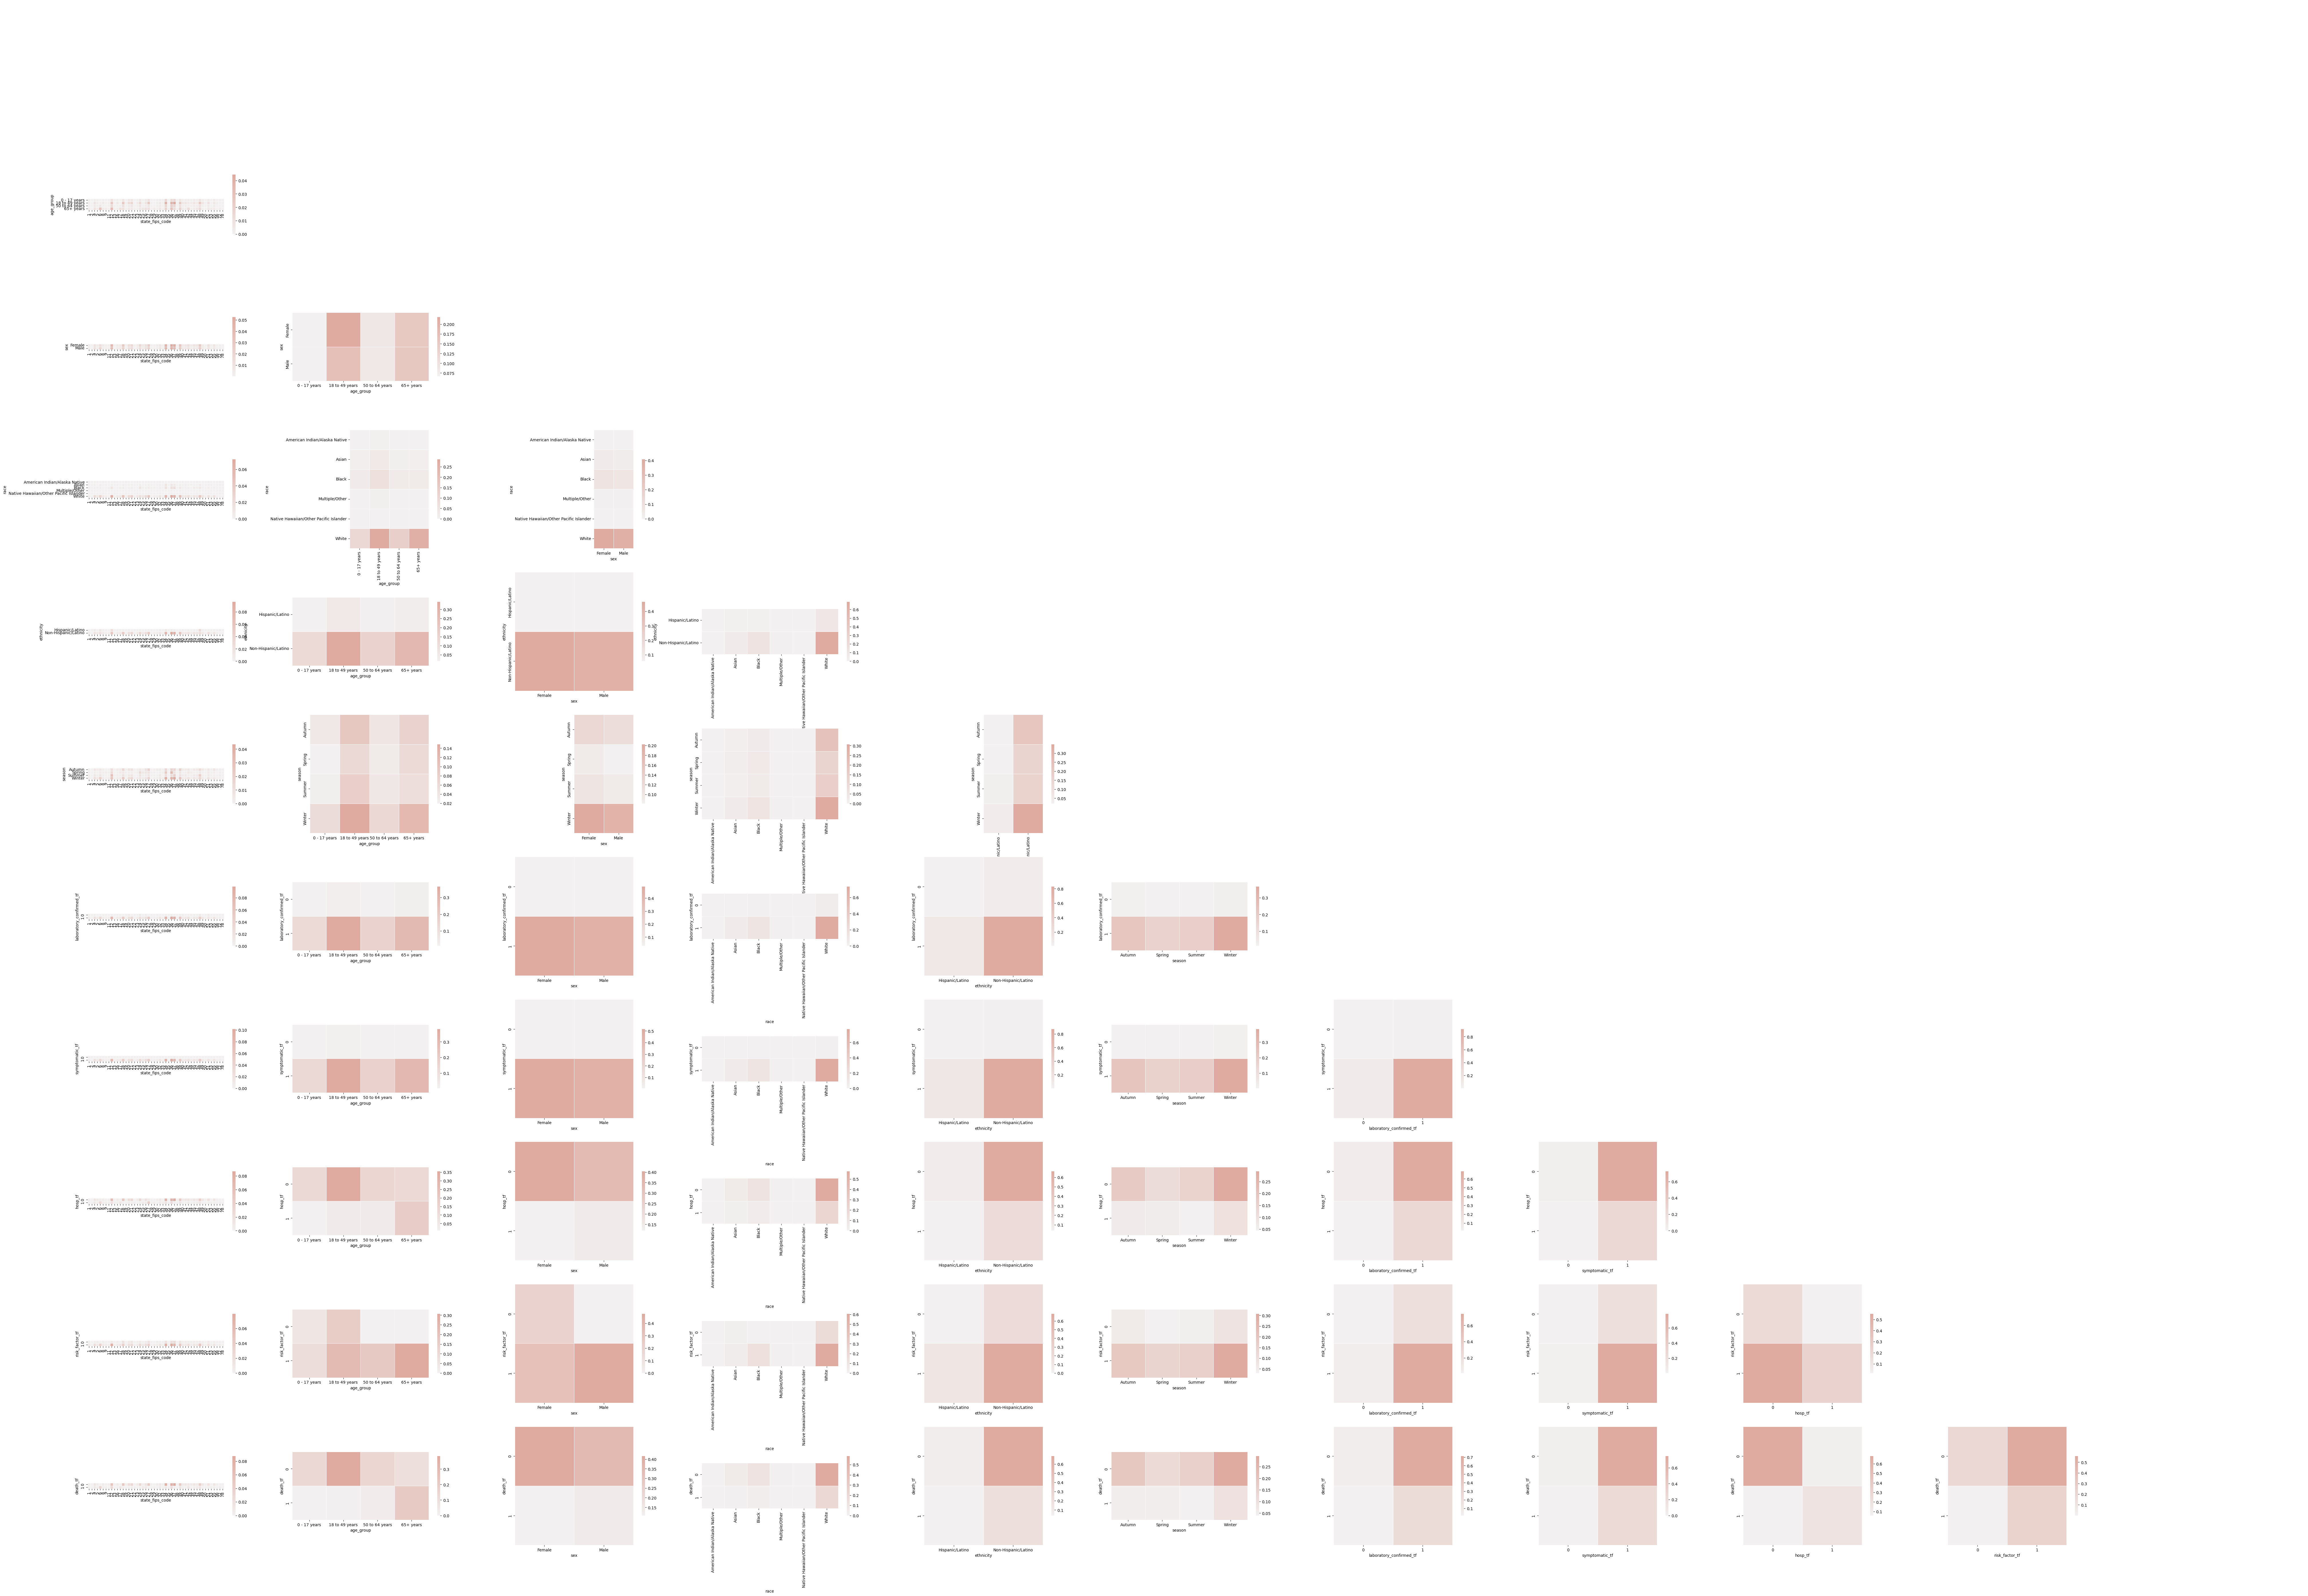

In [290]:
n = len(categorical)

fig, axs = plt.subplots(ncols=n, nrows=n, figsize=(100, 70))

for i, column_i in enumerate(categorical):
    for j, column_j in enumerate(categorical):
        if j < i:
            plotCrosstabHeatmap(data_training, column_i, column_j, axs[i][j])
        else:
            axs[i][j].axis('off')

##### Interpretation of the results
The plots allow us to visualize pairs of features which correlate strongly to each other; areas of the heatmap which are red correspond indicate that there are many patients which fall into that combination of categories, and areas which are cyan correspond to very few. However, there are a few limitations to this visualization, namely when it comes to sample size. If the sample size for one category (e.g., 'White' in the 'Race' feature) is significantly larger than others, it might dominate the heatmap. This makes it appear as though there are stronger associations for that category, even if those are merely due to the larger sample size. Because of this we will simply use this as a tool to understand distribution, rather than a guide for the prediction model.

**Observations**
- Some patient groups have more representation than others. These observations should match the analysis of the data from Task 1.
    - There are many more 'white' patients than non-white.
    - There are many more 'non-hispanic/latino' than 'hispanic/latino' patients.
    - There are many more 'laboratory-confirmed' patients than not.
    - There are many more 'symptomatic' patients than not.
    - There are fewer 'hospitlized' patients than not
- By design there is a correlation between risk factor and some of the other demographic groups. We will keep all of these features for now, but a potential optimization in Part 5 will be to drop either the demographic features or the risk factor feature.

**Features to Remove:** Keeping in mind the limitations stated on this visualization, we will not decide to remove any features based solely on this data.

#### **1.3.2.2 Categorical - Target Plots**
To visually understand the relationships between categorical features and the target, we will plot stacked bar charts. For each value of a category, the bar charts will show us what percentage of patients survived and what percentage died. From there we can analyze the relationships between features and decide whether we want to keep or retain each of the categorical features.

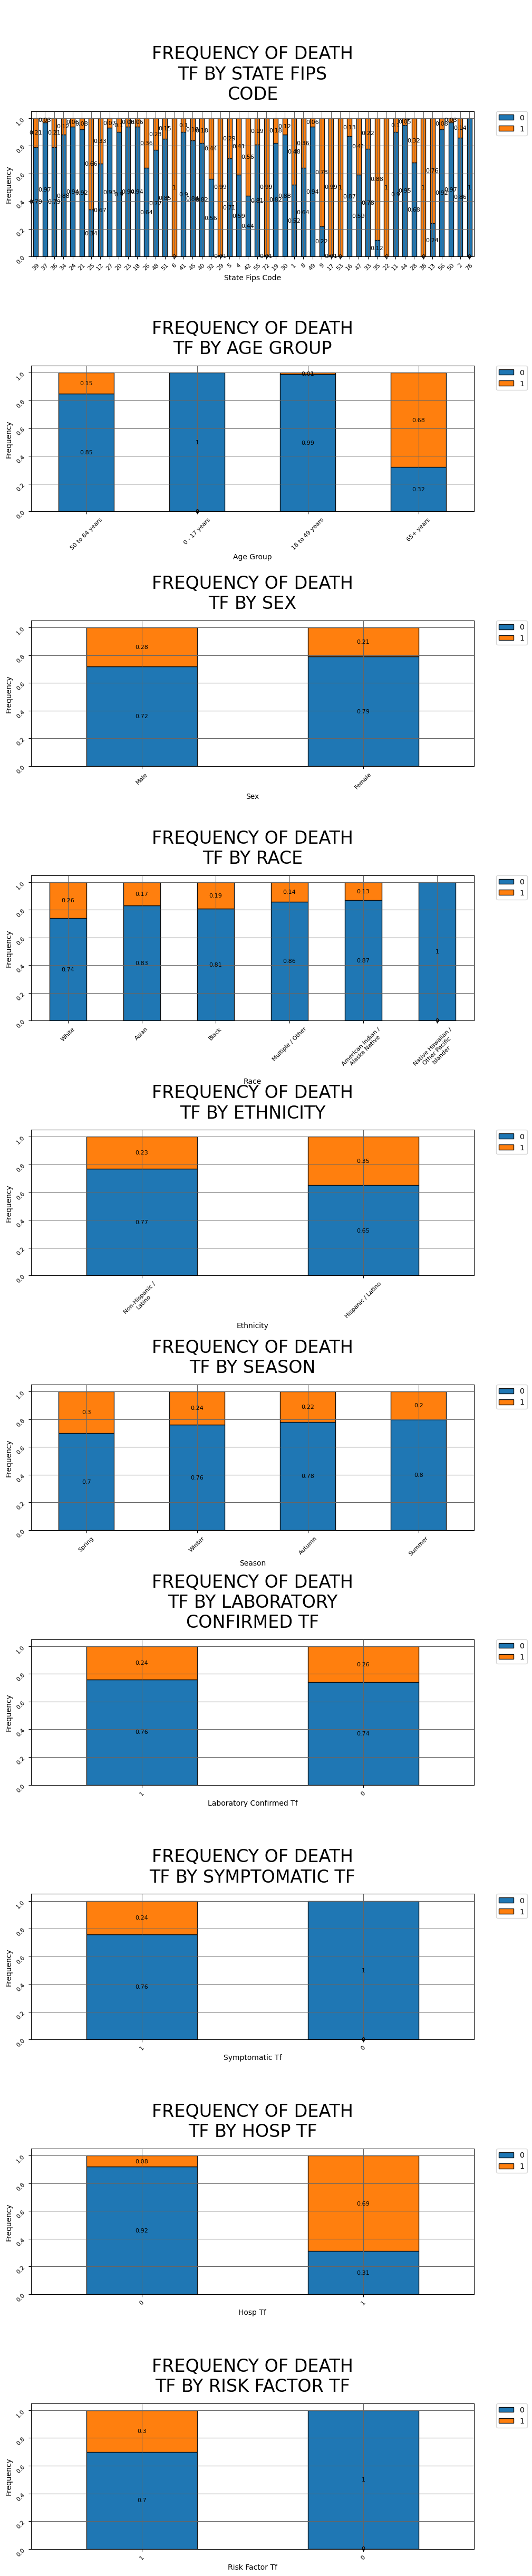

In [291]:
n = len(categorical)-1

fig, axs = plt.subplots(ncols=1, nrows=n, figsize=(6, 60))

for i, feature in enumerate(categorical):
    if feature != 'death_tf':
        createStackedBarChart(data_training, 'death_tf', feature, axs=axs[i] )

##### Interpretation of the results

The stacked bar charts seem to be better indicators of relationships between the features. We will briefly evaluate the relationship between each of the categorical features and death.

**State vs Death**
- Observations of the data reveal an unclear pattern between the state and the occurrence of death. However, it's noteworthy that in 12 states, over 50% of the COVID-19 cases in the study resulted in death.
- This could be due to various factors such as differing state-level responses, demographics, or access to healthcare facilities.
- Despite the lack of a clear pattern, we will retain this feature due to the potential for hidden relationships that might be discovered with further analysis.

**Age Group vs Death**
- There's a strong correlation between age group and death. The death rate for the 0-17 and 18-49 age groups is below 0.01%, but this increases dramatically to 15% for those aged 50-64 and surges to 68% for those aged 65 and above.
- This correlation is to be expected, since it is well known that age is a risk factor for death.
- We will definitely retain this feature due to its strong correlation with the target feature.

**Sex vs Death**
- There appears to be a slight correlation between sex and death. The death rate is 21% for females and 28% for males.
- We will retain this feature, as even slight correlations have the potential to improve the accuracy of the model.

**Race vs Death**
- There's a considerable range in the percentage of cases leading to death among different racial groups. The death rate for white patients is 26%, decreasing to 19% for black patients, 17% for Asian patients, 14% for others, 13% for American Indian/Alaska Natives, and 0% for Native Hawaiian.
- The observed variation might be related to the sample size or other social and health factors.
- We will retain this feature because of the potential for uncovering deeper insights.

**Ethnicity vs Death**
- A significant difference in the occurrence of death between Hispanic/Latino and non-Hispanic/Latino patients is observed, with Hispanic/Latino patients dying more often by 12%.
- We will retain this feature as it shows a notable difference in death rates.

**Season vs Death**
- There appears to be a correlation between season and percent of cases leading to death. The percentage ranges from 20% in Summer to +10% in Spring. Autumn and Winter are somewhere in between.
- We will retain this features as it shows a slight correlation, which has the potential to improve the accuracy of the model.

**Laboratory Confirmed Case vs Death**
- The data shows that the proportion of patients who died with a laboratory-confirmed case is almost equal to the proportion of patients who died without a confirmed case - 24% and 26% respectively.
- This suggests that laboratory confirmation does not significantly impact the likelihood of death.
- Since the feature does not seem to provide valuable predictive power, we will not retain this feature.

**Symptomatic vs Death**
- The data reveals a significant correlation between being symptomatic and death, as no deaths were observed in asymptomatic patients.
- Given the absolute correlation, we will definitely retain this feature.

**Hospitalized vs Death**
- Another strong correlation is seen with hospitalization. Patients who were hospitalized died 69% of the time, compared to an 8% death rate for non-hospitalized patients.
- This is expected because hospitalization is typically indicative of more severe disease.
- We will retain this feature due to its strong correlation with the target feature.

**Risk Factor vs Death**
- The 'Risk Factor' feature, which is an aggregate of several other features, shows a notable correlation with death. No deaths were observed in patients with a risk factor of 0, while a death rate of 30% was noted among patients with a risk factor of 1.
- However, because this feature is a composite of several others, including it might introduce multicollinearity into our model. For this reason, we will include this feature for the moment, but consider eliminating it or the features it encapsulates in later optimization steps.

#### **1.3.2.3 Selection of Indicative Categorical Features**
The set of indicative categorical features we will be using includes the following:
* state_fips_code
* age_group
* sex
* ethnicity
* symptomatic_tf
* hosp_tf
* risk_factor_tf
* season

The only categorical feature to be dropped will be laboratory_confirmed_case_tf

In [292]:
cat_low_correlation_features = ['laboratory_confirmed_tf']

### 1.3.3 Summary & Drop Features

1. The continuous features to be dropped, identified in 1.3.1.4 are as follows:


In [293]:
cont_low_correlation_features

['case_onset_interval']


2. The categorical features to be dropped, identified in 1.3.2.3 are as follows:

In [294]:
cat_low_correlation_features

['laboratory_confirmed_tf']

We will now drop these features
- Before dropping the features, we will duplicate the original dataframe, data_cleaned, and label it model_data
- We will drop the features from model_data, allowing us to revert back to the original dataset when we want to compare the performance of our new dataset with the original.

In [295]:
# Copy the data frame
dropped_column_data = data_cleaned.copy()
# Concatenate the list of features to drop
features_to_drop = cont_low_correlation_features + cat_low_correlation_features
# Drop the features
dropped_column_data = dropped_column_data.drop(columns=features_to_drop)

# Print the new dataframe
dropped_column_data.head(10)

,case_month,state_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,symptomatic_tf,hosp_tf,death_tf,income,people_vaccinated,risk_factor_tf,month_of_year,season
0,2020-11-01,32,65+ years,Female,White,Non-Hispanic/Latino,2,1,1,1,59340,0,1,11,Autumn
1,2021-08-01,4,50 to 64 years,Male,White,Hispanic/Latino,3,1,0,1,64468,206797098,1,8,Summer
2,2020-12-01,12,65+ years,Male,White,Non-Hispanic/Latino,0,1,1,1,52828,5566951,1,12,Winter
3,2020-12-01,6,65+ years,Female,White,Non-Hispanic/Latino,2,1,1,1,68044,5566951,1,12,Winter
4,2020-11-01,48,65+ years,Male,White,Hispanic/Latino,0,1,1,1,57157,0,1,11,Autumn
5,2020-08-01,1,65+ years,Female,White,Non-Hispanic/Latino,0,1,1,1,47583,0,1,8,Summer
6,2021-09-01,16,65+ years,Male,White,Non-Hispanic/Latino,0,1,1,1,52134,215360247,1,9,Autumn
7,2021-11-01,39,65+ years,Female,White,Non-Hispanic/Latino,1,1,1,1,57618,233824494,1,11,Autumn
8,2020-12-01,49,65+ years,Male,White,Non-Hispanic/Latino,0,1,0,1,74865,5566951,1,12,Winter
9,2021-01-01,12,65+ years,Female,White,Hispanic/Latino,0,1,1,1,51347,29890726,1,1,Winter


## 1.4 Prepare Dataset for Modeling

We have now identified the features that we want to use in our predictive models.To prepare them for modeling, we will need to convert all categorical features into dummy variables or integers to allow modeling. We will be using one-hot/dummy encoding for sex, race, ethnicity, and season, and we will use integer encoding for age_group (where it makes sense to preserve the order of categories). The remaining categorical features have already been converted to binary 0 or 1 values, and will not need to be converted for modeling, but we will convert them to uint8 types for memory efficiency. The other integer encoding we will need to do is converting the datetime variable for case_month into a representative integer.

### 1.4.1 Integer encoding

In [296]:
model_data = dropped_column_data.copy()

# Integer encoding of age group
model_data['age_group'] = model_data['age_group'].map({'65+ years': 3, '50 to 64 years': 2, '18 to 49 years': 1, '0 - 17 years': 0}).astype('uint8')

# Integer encoding of case_month column
# Get first case month
min_date = model_data['case_month'].min()
# Subtract min_date from each date in 'case_month', the result will be a datetime.timedelta object
model_data['case_month'] = model_data['case_month'] - min_date
# Convert the timedelta object to number of days and then to months
model_data['case_month'] = (model_data['case_month'] / np.timedelta64(1, 'M')).astype('int64')

# Print datatypes
model_data.dtypes


case_month                            int64
state_fips_code                       uint8
age_group                             uint8
sex                                category
race                               category
ethnicity                          category
case_positive_specimen_interval       int64
symptomatic_tf                        uint8
hosp_tf                               uint8
death_tf                              uint8
income                                int64
people_vaccinated                     int64
risk_factor_tf                        uint8
month_of_year                         int64
season                             category
dtype: object

### 1.4.2 Dummy Encoding

In [297]:
model_data = pd.get_dummies(model_data)
model_data.dtypes

case_month                                     int64
state_fips_code                                uint8
age_group                                      uint8
case_positive_specimen_interval                int64
symptomatic_tf                                 uint8
hosp_tf                                        uint8
death_tf                                       uint8
income                                         int64
people_vaccinated                              int64
risk_factor_tf                                 uint8
month_of_year                                  int64
sex_Female                                     uint8
sex_Male                                       uint8
race_American Indian/Alaska Native             uint8
race_Asian                                     uint8
race_Black                                     uint8
race_Multiple/Other                            uint8
race_Native Hawaiian/Other Pacific Islander    uint8
race_White                                    

#### Redundant Features
We do not need to keep sex_Male, ethnicity_Non-Hispanic/Latino, race_Multiple/Other or season_Autumn since these implied with the falseness of sex_Female, ethnicity_Hispanic/Latino, the other 5 races and the other 3 seasons respectively.

In [298]:
model_data = model_data.drop(columns=['sex_Male','ethnicity_Non-Hispanic/Latino', 'race_Multiple/Other', 'season_Autumn'])

### 1.4.3 Summary
#### Continuous Columns are:

In [299]:
continuous_columns = model_data.select_dtypes(include=['int64']).columns.tolist()
continuous_columns

['case_month',
 'case_positive_specimen_interval',
 'income',
 'people_vaccinated',
 'month_of_year']

##### Categorical Columns are:

In [300]:
categorical_columns = model_data.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['state_fips_code',
 'age_group',
 'symptomatic_tf',
 'hosp_tf',
 'death_tf',
 'risk_factor_tf',
 'sex_Female',
 'race_American Indian/Alaska Native',
 'race_Asian',
 'race_Black',
 'race_Native Hawaiian/Other Pacific Islander',
 'race_White',
 'ethnicity_Hispanic/Latino',
 'season_Spring',
 'season_Summer',
 'season_Winter']

##### Total features are:

In [301]:
features = continuous_columns + categorical_columns
features

['case_month',
 'case_positive_specimen_interval',
 'income',
 'people_vaccinated',
 'month_of_year',
 'state_fips_code',
 'age_group',
 'symptomatic_tf',
 'hosp_tf',
 'death_tf',
 'risk_factor_tf',
 'sex_Female',
 'race_American Indian/Alaska Native',
 'race_Asian',
 'race_Black',
 'race_Native Hawaiian/Other Pacific Islander',
 'race_White',
 'ethnicity_Hispanic/Latino',
 'season_Spring',
 'season_Summer',
 'season_Winter']

### 1.4.4 Train/Test Split
Repeat the process of splitting the data into testing and training data

In [302]:
# Load the dataset into a pandas dataframe and set X and y
features.remove('death_tf')
# descriptive_features = ['case_positive_specimen_interval', 'income', 'people_vaccinated', 'age_group', 'symptomatic_tf', 'hosp_tf', 'sex_Female',  'ethnicity_Hispanic/Latino', 'month_of_year']
target_feature = ['death_tf'] 

X = model_data[features]
y = model_data[target_feature]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("original range is:\t rows 0 to", data_cleaned.shape[0])
print("training range (70%):\t rows 0 to", round(data_training.shape[0]))
print("test range (30%): \t rows", round(data_training.shape[0]), "to", round(data_training.shape[0]) + data_testing.shape[0])

original range is:	 rows 0 to 37940
training range (70%):	 rows 0 to 26558
test range (30%): 	 rows 26558 to 37940


We can see from the X_train printout below that the indexes are no longer consecutive. We need to reset the indices in order to enable merging of the datasets later on.

In [303]:
X_train.head(5)

,case_month,case_positive_specimen_interval,income,people_vaccinated,month_of_year,state_fips_code,age_group,symptomatic_tf,hosp_tf,risk_factor_tf,sex_Female,race_American Indian/Alaska Native,race_Asian,race_Black,race_Native Hawaiian/Other Pacific Islander,race_White,ethnicity_Hispanic/Latino,season_Spring,season_Summer,season_Winter
4635,13,0,49547,108794662,3,39,2,1,0,1,0,0,0,0,0,1,0,1,0,0
8065,3,0,51569,0,5,37,2,1,0,1,1,0,0,0,0,1,1,1,0,0
11826,24,0,49994,251497361,1,37,0,1,0,0,1,0,0,0,0,1,0,0,0,1
12852,20,0,65499,222017432,10,36,1,1,0,1,0,0,0,0,0,1,0,0,0,0
14120,11,0,60955,5566951,12,37,3,1,0,1,0,0,0,0,0,1,0,0,0,1


In [304]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,case_month,case_positive_specimen_interval,income,people_vaccinated,month_of_year,state_fips_code,age_group,symptomatic_tf,hosp_tf,risk_factor_tf,sex_Female,race_American Indian/Alaska Native,race_Asian,race_Black,race_Native Hawaiian/Other Pacific Islander,race_White,ethnicity_Hispanic/Latino,season_Spring,season_Summer,season_Winter
0,13,0,49547,108794662,3,39,2,1,0,1,0,0,0,0,0,1,0,1,0,0
1,3,0,51569,0,5,37,2,1,0,1,1,0,0,0,0,1,1,1,0,0
2,24,0,49994,251497361,1,37,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,20,0,65499,222017432,10,36,1,1,0,1,0,0,0,0,0,1,0,0,0,0
4,11,0,60955,5566951,12,37,3,1,0,1,0,0,0,0,0,1,0,0,0,1


### 1.4.5 Normalize the Dataset
The final step we'll take before beginning to model is to normalize the dataset so that all values are between 0 and 1. This will ensure our features are weighted equally, and also make our coefficients more digestible and informative. We will use sklearn's MinMaxScaler and fit the scaler using only the training data. This will prevent data leakage between the testing and training data. Then we will scale both the training and the testing data.

In [305]:
X_train.dtypes

case_month                                     int64
case_positive_specimen_interval                int64
income                                         int64
people_vaccinated                              int64
month_of_year                                  int64
state_fips_code                                uint8
age_group                                      uint8
symptomatic_tf                                 uint8
hosp_tf                                        uint8
risk_factor_tf                                 uint8
sex_Female                                     uint8
race_American Indian/Alaska Native             uint8
race_Asian                                     uint8
race_Black                                     uint8
race_Native Hawaiian/Other Pacific Islander    uint8
race_White                                     uint8
ethnicity_Hispanic/Latino                      uint8
season_Spring                                  uint8
season_Summer                                 

In [306]:
scaler = MinMaxScaler()

# Fit on the training data
#Because boolean data is already between 1 and 0, only the non-boolean columns need to be scaled
nonboolean = ["case_month", "case_positive_specimen_interval", "income", "people_vaccinated", "month_of_year", "age_group", "state_fips_code"]
scaler.fit(X_train[nonboolean])

# Transform the testing and training data
nonbool_train = pd.DataFrame(scaler.transform(X_train[nonboolean]), columns = X_train[nonboolean].columns)
nonbool_test = pd.DataFrame(scaler.transform(X_test[nonboolean]), columns = X_test[nonboolean].columns)

#Replace the non-boolean values in the datasets with the normalised values
X_train[nonboolean] = nonbool_train
X_test[nonboolean] = nonbool_test

# Also ravel the y_test and y_train for ease of use later on
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

The datasets are now ready for modeling!

In [307]:
def getPredictiveModel(model, X_data: pd.DataFrame, y_data: pd.DataFrame, threshold: float = 0.5):
    """
    Trains a model on the provided data, makes predictions, thresholds these predictions based on the provided 
    threshold, and displays a DataFrame of actual vs. predicted values.

    Parameters:
    model (BaseEstimator): The scikit-learn model to train.
    X_data (DataFrame): The input data for the model.
    y_data (DataFrame or Series): The target data for the model.
    threshold (float): The threshold for deciding predictions. Default is 0.5.

    Returns:
    BaseEstimator: The trained model.
    """
    
    # Fit the model
    model.fit(X_data, y_data)
    
    # Calculate the prediction and threshold the value if it's not a classifier
    if isinstance(model, (LinearRegression,)):
        predictions = (model.predict(X_data) >= threshold) * 1.0
    else:
        predictions = model.predict(X_data)

    # Create a DataFrame with actual vs. predicted values
    actual_vs_predicted = pd.concat([pd.DataFrame(y_data, columns=['Actual']), pd.DataFrame(predictions, columns=['Predicted'])], axis=1)

    # Show the head of the table
    display(actual_vs_predicted.head(100))

    # Return the trained model
    return model

def evaluate_classification(data_type, actual_classification, predicted_classification):
    """
    Evaluate classification results and display metrics.

    Args:
        data_type (str): Type of data ('Test' or 'Training').
        actual_classification (array-like): Actual classification values.
        predicted_classification (array-like): Predicted classification values.
    """
    
    # Display data type
    display(HTML(f"<span style='font-weight:bold; font-size: larger;'>{data_type} Data</span>"))
    
    # Accuracy
    accuracy = metrics.accuracy_score(actual_classification, predicted_classification)
    display(HTML(f"<strong>Accuracy</strong>: {round(accuracy, 4)}"))
    
    # Confusion matrix
    display(HTML(f"<strong>Confusion Matrix</strong>"))
    cm = metrics.confusion_matrix(actual_classification, predicted_classification)
    display(HTML(f"<div style='margin-left:auto; margin-right: auto;'>{tabulate(pd.DataFrame(cm), headers=['Predicted Survival', 'Predicted Death'], showindex=['Actual Survival', 'Actual Death'], tablefmt='html')}</div>"))
    
    # Classification report
    display(HTML(f"<strong>Classification Report</strong>"))
    report = metrics.classification_report(actual_classification, predicted_classification, output_dict=True)
    report.pop('accuracy')
    display(HTML(f"<div style='margin-left:auto; margin-right: auto;'>{tabulate(pd.DataFrame(report).transpose(), headers='keys', tablefmt='html')}</div>"))

# **2.0 Predictive Modeling: Linear Regression** 

## 2.1 Train the Linear Regression Model

We will now create and train a Linear Regression Model to predict our target feature. To do this we will use sklearn's LinearRegression to fit a Linear Regression model with the training data.

In [308]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

## 2.2 Interpret the Linear Regression Model
### **2.2.1 Understanding the Linear Regression Model**

Linear regression is an algorithm used to make predictions based on linear relationships between the target feature and the set of predictive features. It does so by finding the line of best fit to show the relationship between the target and predictors. This line is calculated by minimising the overall error.

The form of the linear regression formula is as follows:
- $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $

In this formula w_0, is the intercept, while w_1 through w_n are the coefficients for each feature. The value of each feature's coefficient is directly tied to the range of the feature. As the feature values have been normalised, we are able to make direct comparisons between them.


### **2.2.2 Coefficients**
We will display the coefficients learned by the model and discuss their role


In [309]:
# Print the weights learned for each feature.
display(HTML(tabulate([('Intercept:', multiple_linreg.intercept_)], tablefmt='html')))

# Display the DataFrame as an HTML table
# Create a list of tuples with features and coefficients
feature_coefficients = list(zip(X_train.columns, multiple_linreg.coef_))

# Sort the list by coefficients in ascending order
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]))

# Display the sorted table using tabulate
display(HTML(tabulate(sorted_feature_coefficients, headers=['Features', 'Coefficients'], tablefmt='html')))

Intercept:,0.0469968


Features,Coefficients
case_positive_specimen_interval,0.00618801
race_Asian,0.00846547
month_of_year,0.0101059
season_Spring,-0.0114852
season_Summer,-0.0120621
race_White,-0.0125554
race_Black,0.0137899
season_Winter,0.0343935
race_Native Hawaiian/Other Pacific Islander,0.04228
race_American Indian/Alaska Native,-0.046775


- Of all the coefficients age_group has the most significant value and a positive correlation. This is not surprising as Covid-19 is known for being more deadly for older people.
- case_month also has a significant value for the coefficient but with a negative correlation. This is also not surprising as the passing of time allowed more measures and strategies to be put in place to improve survival rates.
- hosp_tf has a significant positive coefficient as well, which is not surprising as people who get sick enough with Covid-19 to be hospitalized are more likely to die from the disease.
- state_fips_code having such a significant value is surprising however, as a state's code is a categorical feature so theoretically the code should not be of much significance. This will be investigated further later in this notebook.
- Surprisingly, people_vaccinated has a positive correlation. This is likely due to its relation to case_month, as vaccinated numbers were determined by month. While vaccine numbers plateaued over time, other factors continued to improve survival rates.
- symptomatic_tf has a reasonably significant positive value, but lower than one might expect. This may be because individuals showing the most severe symptoms would be the ones who end up in hospital, allowing for hosp_tf to have an impact on this feature.
- risk_factor_tf has a small negative correlation, which is somewhat unexpected, but taking into account that risk_factor draws its value from several other this result is understandable.
- income also has a negative correlation, which is expected as counties with a higher income are likely to be able to afford better healthcare.
- case_positive_specimen_interval appears to have very little significance which is not surprising as it has little to no relation to patient demographics, the symptoms of the disease, or the wider social context.
- month_of_year also holds only small significance. This is likely a combination of many factors. month_of_year and case_month both describe similar things, and while within each year the general weather changes in a fairly consistent way, with is also accounted for by the seasons.
- The seasons Summer and Spring appear to have very small negative significance, but winter shows a larger positive significance. This is not surprising as viruses often thrive in cold conditions. 
- Sex and race show a reasonably small significance while ethnicity has a somewhat larger significance. This is understandable as there are many factors, both social and biological, that play into sex, ethnicity and race so it is likely that some of these factors would also affect the result an individual getting Covid-19.

### **2.2.3 Target Feature Values and Predicted Class**

Here we will print the predicted target feature value for the first 100 training examples. 
As the target feature is a boolean feature it is necessary to create a threshold for the output to convert it to binary classification. We will set the threshold at 0.5 so that any values >=0.5 will be cast to 1 while any values <0.5 will be cast to 0.

In [310]:
# Calculate the prediction and threshold the value. If >= 0.5 it's true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

# Create a DataFrame with actual vs. predicted values
actual_vs_predicted_multiplelinreg = pd.concat([pd.DataFrame(y_train, columns=['Actual']), pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)

print("\nPredictions with multiple linear regression:")
actual_vs_predicted_multiplelinreg.head(100)


Predictions with multiple linear regression:


,Actual,Predicted
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
95,0,0.0
96,0,0.0
97,0,0.0
98,0,0.0


## 2.3 Evaluate the Linear Regression Model

### **2.3.1 Classification Evaluation Measures on Training Set**

We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1) and then discuss or findings based on these measures


In [311]:
evaluate_classification('Train', y_train, multiple_linreg_predictions_train)

,Predicted Survival,Predicted Death
Actual Survival,19039,1151
Actual Death,1520,4848


,precision,recall,f1-score,support
0,0.926066,0.942992,0.934452,20190
1,0.808135,0.761307,0.784022,6368
macro avg,0.867101,0.852149,0.859237,26558
weighted avg,0.897789,0.899428,0.898383,26558


#### Interpretation of the Results

- Accuracy - How often the model is correct.
    - We have an accuracy of 90%
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
- Precision - What % of the predicted positive are actually positive
    - Precision Positive is 0.81
    - Precision Negative is 0.93
- Recall - What % of the positive values did we predict
    - Recall Positive is 0.76
    - Recall Negative is 0.94
- F1 Score - A weighted average of Precision and Recall
    - F1 Score Positive is 0.78
    - F1 Score Negative is 0.93

#### Summary
While both classes have a fair degree of accuracy, the model is a notably better at predicting the negative class. This makes sense as negative is the majority class; the model has significantly more data to learn from.
In scenarios involving potentially lethal illnesses it is crucial for medical experts to know where to best utilize their limited resources. Because of this, knowing who is at the highest risk of dying can help medical experts to allocate their resources as effectively as possible. Although this model's overall accuracy is good, a high recall value would be the best scenario as it would lead to a higher portion of the people who would die otherwise being recognised as such, allowing them to get the treatment they need.

### **2.3.2 Classification Evaluation Measures on the Testing Set**
We will evaluate the model using classification evaluation measures on the test dataset and compare the results with the evaluation results obtained on the training dataset

In [312]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([pd.DataFrame(y_test, columns=['Actual']), pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)

actual_vs_predicted_multiplelinreg.head(100)


Predictions with multiple linear regression: 



,Actual,Predicted
0,0,0.0
1,0,0.0
2,1,1.0
3,0,0.0
4,0,0.0
...,...,...
95,1,1.0
96,1,1.0
97,0,0.0
98,0,0.0


In [313]:
evaluate_classification('Test', y_test, multiple_linreg_predictions_test)
evaluate_classification('Train', y_train, multiple_linreg_predictions_train)

,Predicted Survival,Predicted Death
Actual Survival,8121,463
Actual Death,639,2159


,precision,recall,f1-score,support
0,0.927055,0.946062,0.936462,8584
1,0.823417,0.771623,0.796679,2798
macro avg,0.875236,0.858843,0.866571,11382
weighted avg,0.901578,0.90318,0.9021,11382


,Predicted Survival,Predicted Death
Actual Survival,19039,1151
Actual Death,1520,4848


,precision,recall,f1-score,support
0,0.926066,0.942992,0.934452,20190
1,0.808135,0.761307,0.784022,6368
macro avg,0.867101,0.852149,0.859237,26558
weighted avg,0.897789,0.899428,0.898383,26558


#### Interpretation of the Results
- Accuracy
    - The accuracy of the test data is marginally higher 90.32% vs 89.94%.
- Precision
    - The precision score for predicting the positive case has increased from 81% to 82%.
    - The precision score for predicting the negative case has remained at 93%.
- Recall
    - The recall score for predicting the positive case has increased from 76% to 77%.
    - The recall score for predicting the negative case has increased from 94% to 95%.
- F1
    - The f1 score for predicting the positive case has increased from 78% to 80%.
    - The f1 score for predicting the negative case has increased from 93% to 94%.

These values are slightly higher than expected as we are now testing the model on new data. The fact that the test scores are close to the train scores is a good sign that the model is generalising. Further comparisons will be made with cross validation.

### **2.3.3 Classification Evaluation Measures on Cross-Validated Set**

We will now perform cross validation on the linear regression model. We will perform the same evaluation as above but multiple times. Each time the data is shuffled, so we get a slightly different dataset for training and testing. This works well for evaluating on a limited set of data

Sklearn provides cross validation functions for both logistic regression and random forests models, but not for linear regression, so we will start by creating our own function to perform this cross validation.

In [314]:
def cross_val_LinReg(X, y, cv=10, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 10. The random state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function to perform 10 fold cross validation and store results into a dataframe. This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall and f1.

In [315]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Perform 10 fold cross validation using cross_val_LinReg_DF function

In [316]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.901327
precision,0.814833
recall,0.765406
f1,0.789335


The results for the cross-validated model seem to align with the results of both the training and testing sets. Like in the previous evaluations, the overall accuracy of the model is rather strong at 90%, but suffers in precision and recall, which reflect the model's difficulty in predicting death.

## 2.4 Interpretation of the Results
Our linear regression model predicting COVID-19 patient outcomes shows a strong performance, with an accuracy of 90.32% on the testing set and 89.94% on the training set. The model's precision for predicting "Survival" cases is 92.71%, and recall is 94.61%. However, for predicting "Death" outcomes, these figures are lower, at 82.34% for precision and 77.16% for recall, suggesting an area for future improvement.

The model's performance remains consistent when using k-fold cross-validation, with average accuracy, precision, recall, and f1-score of 90.13%, 81.48%, 76.54%, and 78.93% respectively across 10 folds.

In terms of the model's coefficients, age_group, case_month, and hosp_tf are among the most significant. Age_group shows a positive correlation, indicating a higher mortality risk for older individuals. Case_month has a negative correlation, reflecting improved survival rates over time. Hosp_tf, representing hospitalization status, has a significant positive correlation, suggesting that patients requiring hospitalization have a higher likelihood of death.

Interestingly, the model assigns a significant value to the state_fips_code variable, a categorical feature that theoretically should not have a strong impact. This warrants further investigation. Similarly, the positive correlation for people_vaccinated is likely due to its association with case_month and merits further exploration.

In conclusion, our linear regression model exhibits robust performance in predicting COVID-19 patient outcomes, with room for improvement, especially in predicting "Death" outcomes. The interpretation of coefficients offers valuable insights into the factors influencing these outcomes, which will guide future model refinement.

# **3.0 Predictive Modeling: Logistic Regression** 

## 3.1 Train the Logistic Regression Model
We will train a pair of logistic regression models to predict the target feature from the training dataset. Because the negative case makes up a much larger portion of the dataset than the positive case, the data is imbalanced. As logistic regression is more affected by class imbalance than linear regression, we will train a logistic regression model for both the unaltered test dataset and a version of the test dataset that uses oversampling to artificially increase the number of positive cases.

In [345]:
# Apply oversampling using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train_log, y_train_log = smote.fit_resample(X_train, y_train)

# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train_log, y_train_log)

X_train_log.head(10)

,case_month,case_positive_specimen_interval,income,people_vaccinated,month_of_year,state_fips_code,age_group,symptomatic_tf,hosp_tf,risk_factor_tf,sex_Female,race_American Indian/Alaska Native,race_Asian,race_Black,race_Native Hawaiian/Other Pacific Islander,race_White,ethnicity_Hispanic/Latino,season_Spring,season_Summer,season_Winter
0,0.382353,0.000000,0.200600,0.406441,0.181818,0.493506,0.666667,1,0,1,0,0,0,0,0,1,0,1,0,0
1,0.088235,0.000000,0.218027,0.000000,0.363636,0.467532,0.666667,1,0,1,1,0,0,0,0,1,1,1,0,0
2,0.705882,0.000000,0.204452,0.939557,0.000000,0.467532,0.000000,1,0,0,1,0,0,0,0,1,0,0,0,1
3,0.588235,0.000000,0.338085,0.829424,0.818182,0.454545,0.333333,1,0,1,0,0,0,0,0,1,0,0,0,0
4,0.323529,0.000000,0.298922,0.020797,1.000000,0.467532,1.000000,1,0,1,0,0,0,0,0,1,0,0,0,1
5,0.705882,0.000000,0.545227,0.939557,0.000000,0.428571,0.000000,1,0,0,1,0,1,0,0,0,0,0,0,1
6,0.794118,0.000000,0.541900,0.966777,0.363636,0.298701,1.000000,1,0,1,0,0,0,0,0,1,0,1,0,0
7,0.588235,0.009615,0.242142,0.829424,0.818182,0.259740,0.333333,1,0,0,1,0,0,0,0,1,0,0,0,0
8,0.852941,0.000000,0.384712,0.978088,0.545455,0.428571,0.333333,1,0,1,0,0,0,0,0,1,0,0,1,0
9,0.382353,0.009615,0.252096,0.406441,0.181818,0.454545,1.000000,1,1,1,0,0,0,0,0,1,0,1,0,0



## 3.2 Interpret the Logistic Regression Model
### **3.2.1 Understanding the Logistic Regression Model**


Logistic regression differs from linear regression in a few ways but there is a direct relationship between the two. Logistic regression also calculates the line of best fit to show the relationship between the target and predictors. Unlike linear regression, logistic regrssion outputs a probability between 0 and 1 to which it applies a default threshhold of 0.5 where values >= 0.5 are cast to 1 and values <0.5 are cast to 0.

The model estimated in logistic regression is given by the following function:

- $probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

In this formula w_0, is the intercept, while w_1 through w_n are the coefficients for each feature. Like linear regression the value of each feature's coefficient is tied to the range of the feature. Again we are able to make direct comparisons between the features as they have been normalised.


### **3.2.2 Coefficients**
We will display the coefficients learned by the model and discuss their role

In [318]:
# Print the weights learned for each feature.
display(HTML(tabulate([('Intercept:', multiple_logisticreg.intercept_)], tablefmt='html')))

# Display the DataFrame as an HTML table
# Create a list of tuples with features and coefficients
feature_coefficients = list(zip(X_train_log.columns, multiple_logisticreg.coef_.ravel()))

# Sort the list by coefficients in ascending order
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]))

# Display the sorted table using tabulate
display(HTML(tabulate(sorted_feature_coefficients, headers=['Features', 'Coefficients'], tablefmt='html')))

Intercept:,-8.48675


Features,Coefficients
race_Native Hawaiian/Other Pacific Islander,-0.0156755
race_Black,-0.0689042
month_of_year,0.151724
race_American Indian/Alaska Native,-0.179648
race_Asian,-0.209368
race_White,-0.223243
season_Summer,-0.254271
sex_Female,-0.361353
season_Winter,0.371802
season_Spring,-0.797699


# 3.3 Evaluate the Logistic Regression Model  
### **3.3.1 Classification Evaluation Measures on Training Set**
To evaluate the logistic regression model we will print out the actual values from the training data and the predicted values, along with the same evaluation measures we have printed for the linear regression models.

In [319]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train_log = (multiple_logisticreg.predict(X_train_log)>= 0.5) * 1.0
multiple_logisticreg_predictions_train = (multiple_logisticreg.predict(X_train)>= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([pd.DataFrame(y_train_log, columns=['Actual']), pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)

actual_vs_predicted_multiplelogisticreg.head(1000)


Predictions with multiple linear regression: 



,Actual,Predicted
0,0,0.0
1,0,1.0
2,0,0.0
3,0,0.0
4,0,1.0
...,...,...
995,0,0.0
996,0,0.0
997,0,0.0
998,0,0.0


In [320]:
evaluate_classification('Oversampled Train', y_train_log, multiple_logisticreg_predictions_train_log)
evaluate_classification('Not Oversampled Train', y_train, multiple_logisticreg_predictions_train)

,Predicted Survival,Predicted Death
Actual Survival,17862,2328
Actual Death,1015,19175


,precision,recall,f1-score,support
0,0.946231,0.884695,0.914429,20190
1,0.891736,0.949728,0.919819,20190
macro avg,0.918983,0.917211,0.917124,40380
weighted avg,0.918983,0.917211,0.917124,40380


,Predicted Survival,Predicted Death
Actual Survival,17862,2328
Actual Death,344,6024


,precision,recall,f1-score,support
0,0.981105,0.884695,0.930409,20190
1,0.721264,0.94598,0.818478,6368
macro avg,0.851185,0.915338,0.874444,26558
weighted avg,0.918801,0.89939,0.903571,26558


#### Interpretation of Results
<span style="color: cyan; font-style: italic"> discuss your findings so far. </span>

<div style="color:lightgreen">


Interpretation of results

- Oversampled Train
    - Accuracy
        - The Oversampled Train has an accuracy of 92%

    - Precision - How good model is a prediction the positive class
        - Precision Positive is 89
        - Precision Negative is 95
    - Recall - What % of the positive values did we predict
        - Recall Positive is 95
        - Recall Negative is 88
    - F1 Score - Is an a weighted average of Precision and recall
        - F1 Score Positive is 91
        - F1 Score Negative is 92
        
- Oversampled Train
    - Accuracy
        - The Not Oversampled Train has an accuracy of 90%

    - Precision - How good model is a prediction the positive class
        - Precision Positive is 72
        - Precision Negative is 98
    - Recall - What % of the positive values did we predict
        - Recall Positive is 95
        - Recall Negative is 88
    - F1 Score - Is an a weighted average of Precision and recall
        - F1 Score Positive is 81
        - F1 Score Negative is 93
    
    


Summary
- These values seem reasonable
- Accuracy is in line with the linear regression model
- The logistic model is also a little better at predicting the negative class.
</div>

### **3.3.2 Classification Evaluation Measures on the Testing Set**
<span style="color: cyan; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

<div style="color: lightgreen">

- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

</div>


In [321]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = (multiple_logisticreg.predict(X_test)>= 0.5) * 1.0

print("\nPredictions with multiple logistic regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([pd.DataFrame(y_test, columns=['Actual']), pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
actual_vs_predicted_multiplelogisticreg.head(100)


Predictions with multiple logistic regression: 



,Actual,Predicted
0,0,0.0
1,0,0.0
2,1,1.0
3,0,0.0
4,0,0.0
...,...,...
95,1,1.0
96,1,1.0
97,0,0.0
98,0,0.0


In [322]:
# Some more evaluation metrics.
evaluate_classification('Test', y_test, multiple_logisticreg_predictions_test)
evaluate_classification('Oversampled Train', y_train_log, multiple_logisticreg_predictions_train_log)

,Predicted Survival,Predicted Death
Actual Survival,7658,926
Actual Death,156,2642


,precision,recall,f1-score,support
0,0.980036,0.892125,0.934016,8584
1,0.740471,0.944246,0.830035,2798
macro avg,0.860253,0.918185,0.882025,11382
weighted avg,0.921144,0.904938,0.908455,11382


,Predicted Survival,Predicted Death
Actual Survival,17862,2328
Actual Death,1015,19175


,precision,recall,f1-score,support
0,0.946231,0.884695,0.914429,20190
1,0.891736,0.949728,0.919819,20190
macro avg,0.918983,0.917211,0.917124,40380
weighted avg,0.918983,0.917211,0.917124,40380


#### Interpretation of Results
<span style="color: cyan; font-style: italic"> discuss your findings so far. </span>

<div style="color:lightgreen">


Interpretation of results

- Accuracy
    - The accuracy of the test data is slightly lower 90.48% vs 91.7%.

- Precision - How good model is a prediction the positive class
    - The precision score for predicting the positive case has reduced from 89% to 74%.
    - The precision score for predicting the negative case has increased from 95% to 98%.

- Recall - What % of the positive values did we predict
    - The recall score for predicting the positive case has reduced from 95% to 94%.
    - The recall score for predicting the negative case has reduced from 88% to 81%.

- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score Positive is 91
    - F1 Score Negative is 92
    - The F1 score for predicting the positive case has reduced from 91% to 83%.
    - The F1 score for predicting the negative case has increased from 92% to 93%.


Summary
- These values seem reasonable
- Accuracy is in line with the linear regression model
- The logistic model is also a little better at predicting the negative class.
</div>





### **3.3.3 Classification Evaluation Measures on Cross-Validated Set**
<span style="color: cyan; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

<div style="color: lightgreen">
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.
</div>

In [323]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarized below

In [324]:
X_log = pd.concat([X_train_log, X_test], axis=0)
y_log = pd.concat([pd.DataFrame(y_train_log, columns=['death_tf']), pd.DataFrame(y_test, columns=['death_tf'])], axis=0)

logRegDF = cross_val_LogReg_DF(X_log,y_log)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.914455
precision,0.879361
recall,0.935792
f1,0.906682


## 3.4 Interpretation of the Results
<span style="color: cyan; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. </span>

<div style="color: lightgreen;">
These results are in line with the previous results. We have taken the mean of 10 sets of results. 
</div>

# **4.0 Predictive Modeling: Random Forest** 

## 4.1 Train the Random Forest Model

We will now create and train a Random Forest model to predict our target feature. To do this we will use sklearn's RandomForestClassifier. We set the number of estimators (number of trees in the forest) to 100 and oob_score to true to use the unused validation data to score the accuracy of the random forest model. Setting the random_state to 1 will make the model deterministic, and we will be able to reproduce the results on subsequent runs.

In [325]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)

## 4.2 Interpret the Random Forest Model

### **4.2.1 Understanding the Random Forest Model**
Like the regression models, Random Forest is a supervised algorithm used for predicting target features based on a set of predictive features. Where they differ is their approach to predicting this data. The random forest model uses an ensemble of decision trees, each of which structures the data in a hierarchical form based on feature values. A decision tree is made up of a root node (or the starting node), interior nodes, and leaf nodes (or the terminating nodes). At each non-leaf node, a test is carried out that will split the feature space into two distinct regions, determining which of the children nodes the process should follow. This process is then repeated until a leaf node is reached, at which point a prediction can be made. The test that is carried out is an if-then-else rule that is meant to split the data based on the highest information gain. This process is similar to a human guessing game, which makes decision trees easy to understand and interpret, while capturing complex relationships between features.  
$~$  
Again, a random forest is an ensemble of decision trees, each of which taking its own approach to creating its decision-making hierarchy. Each decision tree in the ensemble uses a different sample of data points and features (selected through the process of bagging and subspace sampling) to ensure randomness and diversity in each of the decision trees. Once every tree arrives at a prediction, they come to a consensus on the final predicted value. This is either through a majority vote in the case of categorical target features or selecting the median in the case of continuous features.

<img src="./RandomForestModel.png" width="500px">

A few other definitions to help us understand the output of the model are listed below:
- Information Gain - a measure of the reduction in overall entropy of a set of instances that is achieved by testing on a specific feature
- Entropy - the level of disorder or uncertainty in a dataset
- Information Gain Ratio - alternative to entropy-based calculation of information gain; computed by dividing the information gain of a feature by the amount of information used to determine the value of the feature.
- Gini Index - measures how well a particular split separates the data into homogeneous subsets based on their class labels or target values.This value is always between 0 and 1, where 0 means that all data points in the dataset have the same target value, and 1 means that they are perfectly heterogenous.

We will use the Random Forest model to predict whether or not patients will die of Covid considering their descriptive features.
To start, we will look at an example of a single decision tree.

### **4.2.2  Training the Decision Tree**
We will train two decision trees of different depths. One will have a max depth of 4 and the other will have a max depth of 10. This parameter sets the allowable number of levels of the hierarchy before it must give an answer. Otherwise the model would run until all of the nodes are leaf nodes.

In [326]:
# Instantiate a decision tree classifier with a max depth of 4, and a random state of 1 for reproducibility
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
# Train the decision tree model
dtc4.fit(X_train, y_train)

# Instantiate another decision tree classifier with a max depth of 4, and a random state of 1 for reproducibility
dtc4v2 = DecisionTreeClassifier(max_depth=4, random_state=5)
# Train the decision tree model
dtc4v2.fit(X_train, y_train)

# Instantiate a decision tree classifier with a max depth of 10, and a random state of 1 for reproducibility
dtc10 = DecisionTreeClassifier(max_depth=6, random_state=1)
# Train the decision tree model
dtc10.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=1)

###  **4.2.3  Display the Decision tree**
We will create graph of each tree and store as an image.

In [327]:
# create a Graphviz png
with open("images/DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("images/DecisionTree4v2.dot", 'w') as f2:
    f2 = export_graphviz(dtc4v2, out_file=f2, feature_names=X_train.columns)
with open("images/DecisionTree10.dot", 'w') as f3:
    f3 = export_graphviz(dtc10, out_file=f3, feature_names=X_train.columns)

d4tree = open('images/DecisionTree4.dot', 'r').read()
graph4 = pydotplus.graph_from_dot_data(d4tree)
graph4.write_png('images/DecisionTree4.png')

d4treev2 = open('images/DecisionTree4v2.dot', 'r').read()
graph4v2 = pydotplus.graph_from_dot_data(d4treev2)
graph4v2.write_png('images/DecisionTree4v2.png')

d10tree = open('images/DecisionTree10.dot', 'r').read()
graph10 = pydotplus.graph_from_dot_data(d10tree)
graph10.write_png('images/DecisionTree10.png')

True

## 4.2 Interpret the Random Forest Model

### **4.2.1 Understanding the Random Forest Model**
Like the regression models, Random Forest is a supervised algorithm used for predicting target features based on a set of predictive features. Where they differ is their approach to predicting this data. The random forest model uses an ensemble of decision trees, each of which structures the data in a hierarchical form based on feature values. A decision tree is made up of a root node (or the starting node), interior nodes, and leaf nodes (or the terminating nodes). At each non-leaf node, a test is carried out that will split the feature space into two distinct regions, determining which of the children nodes the process should follow. This process is then repeated until a leaf node is reached, at which point a prediction can be made. The test that is carried out is an if-then-else rule that is meant to split the data based on the highest information gain. This process is similar to a human guessing game, which makes decision trees easy to understand and interpret, while capturing complex relationships between features.  
$~$  
Again, a random forest is an ensemble of decision trees, each of which taking its own approach to creating its decision-making hierarchy. Each decision tree in the ensemble uses a different sample of data points and features (selected through the process of bagging and subspace sampling) to ensure randomness and diversity in each of the decision trees. Once every tree arrives at a prediction, they come to a consensus on the final predicted value. This is either through a majority vote in the case of categorical target features or selecting the median in the case of continuous features.

<img src="./images/RandomForestModel.png" width="500px">

A few other definitions to help us understand the output of the model are listed below:
- Information Gain - a measure of the reduction in overall entropy of a set of instances that is achieved by testing on a specific feature
- Entropy - the level of disorder or uncertainty in a dataset
- Information Gain Ratio - alternative to entropy-based calculation of information gain; computed by dividing the information gain of a feature by the amount of information used to determine the value of the feature.
- Gini Index - measures how well a particular split separates the data into homogeneous subsets based on their class labels or target values.This value is always between 0 and 1, where 0 means that all data points in the dataset have the same target value, and 1 means that they are perfectly heterogenous.

We will use the Random Forest model to predict whether or not patients will die of Covid considering their descriptive features.
To start, we will look at an example of a single decision tree.

In [328]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
6,age_group,3.117782e-01
8,hosp_tf,2.111296e-01
5,state_fips_code,1.410940e-01
2,income,1.249208e-01
0,case_month,5.481507e-02
3,people_vaccinated,4.288345e-02
9,risk_factor_tf,2.546868e-02
1,case_positive_specimen_interval,1.939166e-02
4,month_of_year,1.627321e-02
10,sex_Female,1.477077e-02


The list above allows us to see which values are of the most important. It appears that the most important features are age_group (which we already guessed based on the root node of the decision trees we visualized), hosp_tf, state_fips_code, and income. This aligns with some of the features already identified as important in the linear regression, and overlaps with some of the values of the logistic regression. It is important to note that no values have extremely high importance indices. However there are many features with surprisingly low importance, including nearly all of the race features and the seasonal features. These features are candidates for removal in later optimizations.

## 4.3 Evaluate the Random Forest Model

### **4.3.1 Classification Evaluation Measures on the Training Set**
The first step in evaluating the random forest model is to print out the actual values from the training data and the predicted values. We will also print out the classification measures, the accuracy, the confusion matrix, and the precision, recall, F-1 score, and support.

In [329]:
# Using the trained model, on in-sample data (same sample used for training and test), print actual vs predicted values
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})

# Display actual vs predicted
display(df_true_vs_rfc_predicted.head(100))
# Display classification measures
evaluate_classification('Train', y_train, rfc_predictions_train)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


,Predicted Survival,Predicted Death
Actual Survival,20047,143
Actual Death,92,6276


,precision,recall,f1-score,support
0,0.995432,0.992917,0.994173,20190
1,0.977722,0.985553,0.981622,6368
macro avg,0.986577,0.989235,0.987897,26558
weighted avg,0.991185,0.991151,0.991163,26558


The model has achieved exceptional precision, recall, and f1-scores of 99%. While these results may seem impressive due to the extensive features and deep structure used, it is important to be aware of potential overfitting. The risk of overfitting suggests the need to carefully evaluate the model's generalization on the testing set, as it may result in lower accuracy metrics compared to the training data.  
### **4.3.2 Classification Evaluation Measures on the Testing Set**
To really test the predicted model, we apply it to the testing data. We will print out the actual vs predicted class, as well as some evaluation measures, comparing them to the training evaluation measures.

In [330]:
# Using the trained model, on in-sample data (same sample used for training and test), print actual vs predicted values
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

# Display actual vs predicted
display(df_true_vs_rfc_predicted_test.head(100))

# Display classification measures
evaluate_classification('Train', y_train, rfc_predictions_train)
evaluate_classification('Test', y_test, rfc_predictions_test)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
95,1,1
96,1,1
97,0,0
98,0,1


,Predicted Survival,Predicted Death
Actual Survival,20047,143
Actual Death,92,6276


,precision,recall,f1-score,support
0,0.995432,0.992917,0.994173,20190
1,0.977722,0.985553,0.981622,6368
macro avg,0.986577,0.989235,0.987897,26558
weighted avg,0.991185,0.991151,0.991163,26558


,Predicted Survival,Predicted Death
Actual Survival,8188,396
Actual Death,367,2431


,precision,recall,f1-score,support
0,0.957101,0.953868,0.955482,8584
1,0.859922,0.868835,0.864356,2798
macro avg,0.908512,0.911351,0.909919,11382
weighted avg,0.933212,0.932964,0.93308,11382


Based on the provided data, the evaluation measures reveal that the random forest model exhibits an impressive 93% accuracy. This means that it successfully predicted the outcomes of 93% of the patients in the testing set. Notably, the model demonstrates exceptional precision and recall of 95% for correctly identifying the "no death" cases. In other words, when the model predicts "no death," it is accurate 95% of the time and can capture the majority of "no death" instances. However, when it comes to identifying "death" cases, the precision and recall drop slightly to 86%. Although these values are slightly lower, they are still respectable and indicate the model's ability to correctly classify "death" cases in 86% of its predictions while capturing 86% of the actual "death" cases.

Additionally, both the f1-scores and the harmonic mean of precision and recall exhibit similar values for both classes. This consistency is expected since the f1-score represents the balance between precision and recall. Given the similarity in these measures, it can be inferred that the model maintains a balanced performance across both the "no death" and "death" predictions.

It's worth noting that the class distribution in the training set reveals a significant class imbalance, as evidenced by the support column (20190 vs 6368). The relatively lower prevalence of the "death" class in the training data might have contributed to the slightly lower precision and recall for this class. To address this issue and potentially enhance the model's predictive performance for "death" cases, an optimization approach could involve utilizing an oversampled dataset during the training phase. By generating synthetic examples of the minority class, the model would have access to additional information, enabling it to learn more effectively and make better predictions regarding the likelihood of death.
### **4.3.3 Classification Evaluation Measures on Cross-Validated Set**
Another way to check the accuracy of the model is to compare the results with a cross-validated model. We will use k-fold cross-validation, which splits the model into k different datasets and averages the classification evaluation measures for each split. It provides a more reliable estimate of model performance because it ensures that the model is tested against a diverse and random set of samples of the data.

In [331]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

The results for Random Forests are summarized below.

In [332]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
display(HTML(f"<strong>Mean results from 10-fold cross validation</strong>"))
display(RandomForestDF)

# compute the out-of-bag classification accuracy
display(HTML(f"<strong>Out of Bag Score:</strong> {rfc.oob_score_}"))

,Random_Forests
accuracy,0.931945
precision,0.851471
recall,0.870387
f1,0.860705


The results indicate that the average accuracy of the model is about the same as it was when evaluated on the testing dataset, or at about 93%. Just like in the evaluation of the training and testing data sets, precision and recall values specifically for True outcomes of patients are lower. As previously mentioned, the under-representation of patients who died in the dataset impacts the accuracy of these values. To address this issue, oversampling techniques could be implemented, providing the decision trees with more information about patients at risk of COVID-related death. Despite this limitation, the model correctly predicting positive cases 85% of the time that it predicts positive (precision) and identifying patients who actually died 87% of the time (recall).

Additionally, the Out of Bag (OOB) score, which estimates the model's performance on unseen data during training, is calculated to be 92.9%. This means that testing on samples that were left out of the individual decision trees averaged to 92.9%. This is in line with the accuracy of the testing, training, and cross validated sets.

## 4.4 Interpretation of the Results
Building on the initial analysis, our random forest model predicting COVID-19 patient outcomes exhibits pretty good performance with an accuracy of 93% on the testing set. The model demonstrates remarkable precision and recall for correctly identifying "no death" cases, demonstrating accuracy and completeness of 95%. However, for "death" cases, these metrics reduce to 86%, a potential area for future optimization.

The f1-scores, which represent the harmonic mean of precision and recall, provide similar readings for both classes, indicating a balanced performance. Despite this, the model shows a class imbalance in the training set, with "death" cases underrepresented, potentially leading to the lower precision and recall for this class.

The model's accuracy remains consistent when using k-fold cross-validation, averaging at around 93%. The Out of Bag (OOB) score, used to estimate the model's performance on unseen data during training, aligns closely with this, calculated to be 92.9%.

In terms of future optimizations, several approaches can be considered. Reducing the maximum depth of the decision trees could help mitigate potential overfitting and improve the model's generalizability. The feature 'state_fips_code' seems to be falsely interpreted as a continuous variable by the model, which can potentially skew the results, making it might potentially beneficial to remove this feature in future iterations. Finally, other features with lower importance could also be eliminated to simplify the model and improve its efficiency without significantly affecting its predictive performance. Applying these adjustments would streamline our model, potentially enhancing its predictive capabilities and interpretability.

# **5.0 Optimizations & Conclusion**

To establish a baseline for comparison, we will create a simple model which always predicts the majority class, and print out its confusion matrix and classification report.

In [333]:
majority_class = 0
simple_majority = [majority_class] * len(y_test)

evaluate_classification('Simple Majority', y_test, simple_majority)

,Predicted Survival,Predicted Death
Actual Survival,8584,0
Actual Death,2798,0


,precision,recall,f1-score,support
0,0.754173,1,0.859862,8584
1,0,0,0,2798
macro avg,0.377087,0.5,0.429931,11382
weighted avg,0.568777,0.754173,0.648485,11382



## 5.1 Model Comparison and Justification
Three models were built to predict COVID-19 outcomes: linear regression, logistic regression, and a random forest model. All three models demonstrated acceptable performance with the logistic regression model outperforming the others in terms of precision and recall after oversampling the minority class. This was an important step, given the class imbalance in the data, where the number of survivors vastly outnumbered the fatalities. The random forest model, however, showed the highest accuracy. The table below summarizes accuracy, prediction, recall, and f1-score for the 3 models, and compares them with the values for the simple majority (using the false values rather than positive). All three models perform better in all accuracy and precision than simply taking the simple majority.

| |Simple Majority (Invert)|Linear Regression|Logistic Regression|Random Forest|
|:----|:----|:----|:----|:----|
|accuracy|0.754173|0.901327|0.915343|0.931444|
|precision|0.754173|0.814833|0.879845|0.850861|
|recall|1|0.765406|0.937446|0.868752|
|f1|0.859862|0.789335|0.907706|0.859583|

We expect that with similar oversampling steps, the random forest model could achieve comparable precision and recall metrics to the logistic regression model. For this reason, we will say that the random forest model performs the best, and verify this assumption in our optimization steps.


## 5.2 Understanding of the Problem and Predictive Modeling Results
The predictive modeling results revealed some valuable insights into the features contributing to COVID-19 outcomes. Age_group, hospitalization, symptom_status, people_vaccinated, and state_fips_code were identified as important features across all models. However, some issues were noted. The state_fips_code was treated as a continuous variable when it should have been handled as a categorical variable. Additionally, the inclusion of hospitalization is questionable as this information may not be available at the time of contracting COVID-19.

Class imbalance was also identified as a potential issue, with a significantly higher number of survivors than fatalities. This imbalance can lead to biased models with lower precision and recall for the minority class - in this case, patient death. Thus, the models had less information to correctly predict patient death, leading to less-than-optimal predictive performance for this category.

## 5.3 Ideas for Improvement and Implementation

### 5.3.1 Random Forest Optimization  
We will write a function that will allows us to modify the random forest model and view the results.

In [334]:
def train_and_evaluate_random_forest(X_train, y_train, n_estimators=100, max_features='auto', max_depth=None, X_test=X_test):
    # Train RF with specified number of trees and max features
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, oob_score=True, random_state=1)
    rfc.fit(X_train, y_train)

    # Show the feature importance
    importance = pd.DataFrame({'feature': X_train.columns, 'importance': rfc.feature_importances_})
    display(importance.sort_values('importance', ascending=False))

    # Using the trained model, on in-sample data (same sample used for training and test), print actual vs predicted values
    rfc_predictions_train = rfc.predict(X_train)
    df_true_vs_rfc_predicted_train = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})

    # Using the trained model, on out-of-sample data (test set), print actual vs predicted values
    rfc_predictions_test = rfc.predict(X_test)
    df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})

    # Display classification measures
    evaluate_classification('Train', y_train, rfc_predictions_train)
    evaluate_classification('Test', y_test, rfc_predictions_test)

#### 5.3.1.1 Optimization 1 - Addressing Class Imbalance
**Oversampling**

Our first approach to optimizing the model involves oversampling the minority class. This technique is designed to address the class imbalance in our data. We will try an undersampling the dominant target feature in a step down below. For now we will assess the accuracy precision and recall of the random forest model before and after oversampling.

In [335]:
smote = SMOTE(sampling_strategy='minority')
X_train_opt1, y_train_opt1 = smote.fit_resample(X_train, y_train)

train_and_evaluate_random_forest(X_train_opt1, y_train_opt1)

,feature,importance
6,age_group,3.875273e-01
8,hosp_tf,1.901710e-01
5,state_fips_code,1.077036e-01
2,income,8.559164e-02
0,case_month,5.362177e-02
9,risk_factor_tf,4.885396e-02
3,people_vaccinated,4.316701e-02
1,case_positive_specimen_interval,2.327661e-02
4,month_of_year,1.611522e-02
10,sex_Female,1.069135e-02


,Predicted Survival,Predicted Death
Actual Survival,20020,170
Actual Death,67,20123


,precision,recall,f1-score,support
0,0.996665,0.99158,0.994116,20190
1,0.991623,0.996682,0.994146,20190
macro avg,0.994144,0.994131,0.994131,40380
weighted avg,0.994144,0.994131,0.994131,40380


,Predicted Survival,Predicted Death
Actual Survival,8126,458
Actual Death,308,2490


,precision,recall,f1-score,support
0,0.963481,0.946645,0.954989,8584
1,0.84464,0.889921,0.86669,2798
macro avg,0.904061,0.918283,0.910839,11382
weighted avg,0.934267,0.932701,0.933283,11382


**Undersampling**

As an alternative to oversampling, we also explore undersampling the majority class to tackle the issue of class imbalance.

In [336]:
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of the RandomUnderSampler
rus = RandomUnderSampler()

X_train_opt1_2, y_train_opt1_2 = rus.fit_resample(X_train, y_train)

train_and_evaluate_random_forest(X_train_opt1_2, y_train_opt1_2)

,feature,importance
6,age_group,0.377652
8,hosp_tf,0.197667
5,state_fips_code,0.107880
2,income,0.096391
0,case_month,0.052532
9,risk_factor_tf,0.044290
3,people_vaccinated,0.040877
4,month_of_year,0.016062
1,case_positive_specimen_interval,0.014688
10,sex_Female,0.012352


,Predicted Survival,Predicted Death
Actual Survival,6314,54
Actual Death,28,6340


,precision,recall,f1-score,support
0,0.995585,0.99152,0.993548,6368
1,0.991555,0.995603,0.993575,6368
macro avg,0.99357,0.993562,0.993562,12736
weighted avg,0.99357,0.993562,0.993562,12736


,Predicted Survival,Predicted Death
Actual Survival,7900,684
Actual Death,139,2659


,precision,recall,f1-score,support
0,0.982709,0.920317,0.95049,8584
1,0.795393,0.950322,0.865983,2798
macro avg,0.889051,0.935319,0.908237,11382
weighted avg,0.936662,0.927693,0.929716,11382


The difference in models is as follows:

| |Original Random Forest| Optimization 1  (Oversampled)|Optimization 1  (Undersampled)|
|:----|:----|:----|:----|
|accuracy|0.931444|0.9324| 0.9258|
|precision|0.850861|0.844248| 0.790428|
|recall|0.868752|0.889207| 0.950322|
|f1|0.859583|0.866144| 0.863031|

The overall accuracy and precision of the model have decreased, but recall and f1 have both increased. In the case of COVID-19, recall may be the more important factor, where we are more concerned with over-predicting death and taking steps to try to prevent it, so we determine that the oversampled model performs better.

#### 5.3.1.2 Optimization 2 - Set Maximum Depth

For our third optimization, we will limit the maximum depth of the model. This strategy may not enhance accuracy, but it aims to streamline the model by reducing its complexity.

In [337]:
X_train_opt2 = X_train_opt1.copy()
y_train_opt2 = y_train_opt1.copy()

train_and_evaluate_random_forest(X_train_opt2, y_train_opt2, max_depth = 4)

,feature,importance
6,age_group,0.481089
8,hosp_tf,0.234121
5,state_fips_code,0.069836
9,risk_factor_tf,0.069794
0,case_month,0.064307
3,people_vaccinated,0.040520
1,case_positive_specimen_interval,0.015834
2,income,0.007065
17,season_Spring,0.004465
16,ethnicity_Hispanic/Latino,0.003049


,Predicted Survival,Predicted Death
Actual Survival,17915,2275
Actual Death,775,19415


,precision,recall,f1-score,support
0,0.958534,0.88732,0.921553,20190
1,0.895113,0.961615,0.927173,20190
macro avg,0.926823,0.924468,0.924363,40380
weighted avg,0.926823,0.924468,0.924363,40380


,Predicted Survival,Predicted Death
Actual Survival,7699,885
Actual Death,147,2651


,precision,recall,f1-score,support
0,0.981264,0.896901,0.937188,8584
1,0.749717,0.947462,0.83707,2798
macro avg,0.865491,0.922182,0.887129,11382
weighted avg,0.924344,0.909331,0.912576,11382


The difference in models is as follows:

| |Original Random Forest| Optimization 1  (Oversampled)|Optimization 1  (Undersampled)| Optimization 2 |
|:----|:----|:----|:----|:----|
|accuracy|0.9314|0.9324| 0.9258|0.9185
|precision|0.850861|0.844248| 0.790428| 0.779271|
|recall|0.868752|0.889207| 0.950322|0.932452|
|f1|0.859583|0.866144| 0.863031| 0.849007|


#### 5.3.1.3 Optimization 3 - Remove Unnecessary Features

Our fourth optimization involves eliminating features that are not influential in our model's predictions. We categorize features with an importance value of less than 0.05 as unimportant.

In [338]:
# Get the list of column names starting with "race", "sex", or "season"
columns_to_drop = [col for col in X_train_opt1.columns if col.startswith(('hosp', 'race', 'season', 'sex', 'case_positive_specimen_interval', 'income', 'ethnicity', 'month_of_year'))]

# Drop the specified columns from X_train
X_train_opt3 = X_train_opt2.drop(columns=columns_to_drop)
y_train_opt3 = y_train_opt2.copy()
X_test_opt3 = X_test.drop(columns=columns_to_drop)

train_and_evaluate_random_forest(X_train_opt3, y_train_opt3, max_depth = 4, X_test = X_test_opt3 )

,feature,importance
3,age_group,0.662357
5,risk_factor_tf,0.116868
0,case_month,0.091849
2,state_fips_code,0.071359
1,people_vaccinated,0.052886
4,symptomatic_tf,0.004681


,Predicted Survival,Predicted Death
Actual Survival,18085,2105
Actual Death,1482,18708


,precision,recall,f1-score,support
0,0.92426,0.89574,0.909777,20190
1,0.898861,0.926597,0.912519,20190
macro avg,0.911561,0.911169,0.911148,40380
weighted avg,0.911561,0.911169,0.911148,40380


,Predicted Survival,Predicted Death
Actual Survival,7755,829
Actual Death,254,2544


,precision,recall,f1-score,support
0,0.968286,0.903425,0.934732,8584
1,0.754225,0.909221,0.824502,2798
macro avg,0.861255,0.906323,0.879617,11382
weighted avg,0.915664,0.90485,0.907634,11382


The difference in models is as follows:

| |Original Random Forest| Optimization 1  (Oversampled)|Optimization 1  (Undersampled)| Optimization 2 | Optimization 3|
|:----|:----|:----|:----|:----|:----|
|accuracy|0.9314|0.9324| 0.9258|0.9185 | 0.9047|
|precision|0.850861|0.844248| 0.790428| 0.779271|0.752134|
|recall|0.868752|0.889207| 0.950322|0.932452|0.913152|
|f1|0.859583|0.866144| 0.863031| 0.849007|0.824859|


#### 5.3.1.4 Optimization 4 - Remove Collinear Features

Our fifth optimization step is aimed at eliminating collinear features from the model. In our case, the 'risk_factor' and 'age_group' features exhibit collinearity. Thus, we choose to remove 'risk_factor', which encapsulates certain demographic features, including 'age_group'.

In [339]:
# Get the list of column names starting with "race", "sex", or "season"
columns_to_drop = [col for col in X_train_opt1.columns if col.startswith(('risk_factor'))]

# Drop the specified columns from X_train
X_train_opt4 = X_train_opt3.drop(columns=columns_to_drop)
y_train_opt4 = y_train_opt3.copy()
X_test_opt4 = X_test_opt3.drop(columns=columns_to_drop)

train_and_evaluate_random_forest(X_train_opt4, y_train_opt4, max_depth = 4, X_test = X_test_opt4 )

,feature,importance
3,age_group,0.767235
0,case_month,0.092131
2,state_fips_code,0.078265
1,people_vaccinated,0.058134
4,symptomatic_tf,0.004236


,Predicted Survival,Predicted Death
Actual Survival,18096,2094
Actual Death,1452,18738


,precision,recall,f1-score,support
0,0.925721,0.896285,0.910766,20190
1,0.899482,0.928083,0.913559,20190
macro avg,0.912601,0.912184,0.912162,40380
weighted avg,0.912601,0.912184,0.912162,40380


,Predicted Survival,Predicted Death
Actual Survival,7756,828
Actual Death,252,2546


,precision,recall,f1-score,support
0,0.968531,0.903541,0.934908,8584
1,0.754594,0.909936,0.825016,2798
macro avg,0.861563,0.906739,0.879962,11382
weighted avg,0.91594,0.905113,0.907894,11382


The difference in models is as follows:

| |Original Random Forest| Optimization 1  (Oversampled)|Optimization 1  (Undersampled)| Optimization 2 | Optimization 3|Optimization 4|
|:----|:----|:----|:----|:----|:----|:----|
|accuracy|0.9314|0.9324| 0.9258|0.9185 | 0.9047| 0.9044|
|precision|0.850861|0.844248| 0.790428| 0.779271|0.752134|0.750146|
|recall|0.868752|0.889207| 0.950322|0.932452|0.913152|0.916369|
|f1|0.859583|0.866144| 0.863031| 0.849007|0.824859|0.824968|


#### 5.3.1.5 Optimization 5 - Remove Strange Features

The next optimization we will attempt is to remove state_fips_code. This feature is an interesting one because it is currently one of the most important factors in predicting patient outcome, but it is being misinterpreted by the model. The model is treating state_fips_codes as continuous numeric values, and testing for it based on relational values when in fact there is no relationship between state number and state. We will try removing it and assessing the impact on the accuracy of the model.

In [340]:
# Get the list of column names starting with "race", "sex", or "season"
columns_to_drop = [col for col in X_train_opt1.columns if col.startswith(('state'))]

# Drop the specified columns from X_train
X_train_opt5 = X_train_opt4.drop(columns=columns_to_drop)
y_train_opt5 = y_train_opt4.copy()
X_test_opt5 = X_test_opt4.drop(columns=columns_to_drop)

train_and_evaluate_random_forest(X_train_opt5, y_train_opt5, max_depth = 4, X_test = X_test_opt5 )

,feature,importance
2,age_group,0.836813
0,case_month,0.100728
1,people_vaccinated,0.056499
3,symptomatic_tf,0.005960


,Predicted Survival,Predicted Death
Actual Survival,18059,2131
Actual Death,2022,18168


,precision,recall,f1-score,support
0,0.899308,0.894453,0.896874,20190
1,0.895019,0.899851,0.897429,20190
macro avg,0.897164,0.897152,0.897151,40380
weighted avg,0.897164,0.897152,0.897151,40380


,Predicted Survival,Predicted Death
Actual Survival,7701,883
Actual Death,331,2467


,precision,recall,f1-score,support
0,0.95879,0.897134,0.926938,8584
1,0.736418,0.881701,0.802537,2798
macro avg,0.847604,0.889418,0.864738,11382
weighted avg,0.904125,0.89334,0.896357,11382


The difference in models is as follows:

| |Original Random Forest| Optimization 1  (Oversampled)|Optimization 1  (Undersampled)| Optimization 2 | Optimization 3|Optimization 4|Optimization 5|
|:----|:----|:----|:----|:----|:----|:----|:----|
|accuracy|0.9314|0.9324| 0.9258|0.9185 | 0.9047| 0.9044| 0.8996|
|precision|0.850861|0.844248| 0.790428| 0.779271|0.752134|0.750146|0.756113	|
|recall|0.868752|0.889207| 0.950322|0.932452|0.913152|0.916369|0.873124|
|f1|0.859583|0.866144| 0.863031| 0.849007|0.824859|0.824968|0.810416	|

The inclusion of state_fips_code does not have a significant impact on accuracy or precision, but does significantly reduce recall (~4%). For this reason, we will retain state_fips_code.

#### 5.3.1.6 Optimization 6 - Remove More Unnecessary Features

Our last optimization will be to attempt to remove symtomatic_tf. It contributes significantly less to the outcome than the other four values remaining in the dataset based on importance factors (about 10% of the next most important factor).

In [341]:
# Get the list of column names starting with "race", "sex", or "season"
columns_to_drop = [col for col in X_train_opt1.columns if col.startswith(('symptomatic'))]

# Drop the specified columns from X_train
X_train_opt6 = X_train_opt4.drop(columns=columns_to_drop)
y_train_opt6 = y_train_opt4.copy()
X_test_opt6 = X_test_opt4.drop(columns=columns_to_drop)

train_and_evaluate_random_forest(X_train_opt6, y_train_opt6, max_depth = 4, X_test = X_test_opt6 )

,feature,importance
3,age_group,0.772401
0,case_month,0.100332
2,state_fips_code,0.081752
1,people_vaccinated,0.045515


,Predicted Survival,Predicted Death
Actual Survival,18040,2150
Actual Death,1427,18763


,precision,recall,f1-score,support
0,0.926696,0.893512,0.909802,20190
1,0.897193,0.929321,0.912975,20190
macro avg,0.911945,0.911417,0.911388,40380
weighted avg,0.911945,0.911417,0.911388,40380


,Predicted Survival,Predicted Death
Actual Survival,7743,841
Actual Death,248,2550


,precision,recall,f1-score,support
0,0.968965,0.902027,0.934299,8584
1,0.751991,0.911365,0.824043,2798
macro avg,0.860478,0.906696,0.879171,11382
weighted avg,0.915627,0.904323,0.907195,11382


The difference in models is as follows:

| |Original Random Forest| Optimization 1  (Oversampled)|Optimization 1  (Undersampled)| Optimization 2 | Optimization 3|Optimization 4|Optimization 5| Optimization 6|
|:----|:----|:----|:----|:----|:----|:----|:----|:----|
|accuracy|0.9314|0.9324| 0.9258|0.9185 | 0.9047| 0.9044| 0.8996|0.9041|
|precision|0.850861|0.844248| 0.790428| 0.779271|0.752134|0.750146|0.756113	|0.750956|
|recall|0.868752|0.889207| 0.950322|0.932452|0.913152|0.916369|0.873124|0.912795|
|f1|0.859583|0.866144| 0.863031| 0.849007|0.824859|0.824968|0.810416	|0.824004|

#### 5.3.1.7 Conclusions
From the optimizations made in the model, it seems like improvements can be made to the performance of the model, without sacrificing too much of the accuracy of the predictions. We have not been able to successfully mitigate the large disparity in precision and recall for deaths, but the optimizations presented have shrunk the amount of features to only 4 and limited the max depth of the decision tree to 4 whilsty preserving an overall accuracy of 90%+. For completeness, we will also attempt some optimizations on the logistic regression model, which did had better precision and recall values than the random forest model.

### 5.3.2 Logistic Regression Optimization

In [342]:
def train_and_evaluate_logistic_regression(X_train, y_train, X_test=X_test):

    multiple_logisticreg = LogisticRegression().fit(X_train, y_train)
    # calculate the prediction and threshold the value. If >= 0.5 its true
    multiple_logisticreg_predictions_test = (multiple_logisticreg.predict(X_test)>= 0.5) * 1.0

    # Show feature coeffficients
    # Create a list of tuples with features and coefficients
    feature_coefficients = list(zip(X_train.columns, multiple_logisticreg.coef_.ravel()))
    # Sort the list by coefficients in ascending order
    sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]))
    # Display the sorted table using tabulate
    display(HTML(tabulate(sorted_feature_coefficients, headers=['Features', 'Coefficients'], tablefmt='html')))

    # Using the trained model, on in-sample data (same sample used for training and test), print actual vs predicted values
    multiple_logisticreg_predictions_train = (multiple_logisticreg.predict(X_train)>= 0.5) * 1.0
    multiple_logisticreg_predictions_test = (multiple_logisticreg.predict(X_test)>= 0.5) * 1.0

    actual_vs_predicted_multiplelogisticreg = pd.concat([pd.DataFrame(y_train, columns=['Actual']), pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
    actual_vs_predicted_multiplelogisticreg = pd.concat([pd.DataFrame(y_test, columns=['Actual']), pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)

    # Display classification measures
    evaluate_classification('Train', y_train, multiple_logisticreg_predictions_train)
    evaluate_classification('Test', y_test, multiple_logisticreg_predictions_test)

#### 5.3.2.1 Optimzation 1 - Remove Unnecessary Features
We've already handled oversampling for the logistic regression, so the first optimization we will attempt is to remove unnecessary features. In this step we've defined unnecessary features as features with importance of less than 0.05. The features we will drop from the training and testing data are 'hosp', 'race', 'sex',  'season', 'case_positive_specimen_interval', 'income', 'ethnicity', and 'month_of_year'.

In [343]:
smote = SMOTE(sampling_strategy='minority')
X_train_log, y_train_log = smote.fit_resample(X_train, y_train)

# Get the list of column names starting with "race", "sex", or "season"
columns_to_drop = [col for col in X_train_opt1.columns if col.startswith(('hosp', 'race', 'season', 'sex', 'case_positive_specimen_interval', 'income', 'ethnicity', 'month_of_year'))]

# Drop the specified columns from X_train
X_train_log_opt1 = X_train_log.drop(columns=columns_to_drop)
y_train_log_opt1 = y_train_log.copy()
X_test_log_opt1 = X_test.drop(columns=columns_to_drop)

train_and_evaluate_logistic_regression(X_train_log_opt1, y_train_log_opt1, X_test = X_test_log_opt1 )

Features,Coefficients
people_vaccinated,1.96676
risk_factor_tf,2.07062
state_fips_code,-2.17029
symptomatic_tf,4.7412
case_month,-6.51681
age_group,7.90808


,Predicted Survival,Predicted Death
Actual Survival,17348,2842
Actual Death,1684,18506


,precision,recall,f1-score,support
0,0.911517,0.859237,0.884606,20190
1,0.866873,0.916592,0.89104,20190
macro avg,0.889195,0.887915,0.887823,40380
weighted avg,0.889195,0.887915,0.887823,40380


,Predicted Survival,Predicted Death
Actual Survival,7431,1153
Actual Death,257,2541


,precision,recall,f1-score,support
0,0.966571,0.86568,0.913348,8584
1,0.687872,0.908149,0.78281,2798
macro avg,0.827222,0.886915,0.848079,11382
weighted avg,0.89806,0.87612,0.881258,11382


The difference in models is as follows:

| |Original Logistic Regression | Optimization 1|
|:----|:----|:----|
|accuracy|0.9153|0.876|
|precision|0.814833|0.0687686|
|recall|0.765406|0.908149|
|f1|0.789335|0.782689|

#### 5.3.2.2 Optimization 2 - Remove Collinear Features
We will remove 'risk_factor_tf' in trying to optimize the logistic regression for the same reason that we removed it from the random forest model.

In [344]:
# Get the list of column names starting with "race", "sex", or "season"
columns_to_drop = [col for col in X_train_opt1.columns if col.startswith(('risk'))]

# Drop the specified columns from X_train
X_train_log_opt2 = X_train_log_opt1.drop(columns=columns_to_drop)
y_train_log_opt2 = y_train_log_opt1.copy()
X_test_log_opt2 = X_test_log_opt1.drop(columns=columns_to_drop)

train_and_evaluate_logistic_regression(X_train_log_opt2, y_train_log_opt2, X_test = X_test_log_opt2 )

Features,Coefficients
people_vaccinated,1.99507
state_fips_code,-2.19918
symptomatic_tf,4.76143
case_month,-6.58586
age_group,8.28504


,Predicted Survival,Predicted Death
Actual Survival,17441,2749
Actual Death,1794,18396


,precision,recall,f1-score,support
0,0.906733,0.863843,0.884769,20190
1,0.869993,0.911144,0.890093,20190
macro avg,0.888363,0.887494,0.887431,40380
weighted avg,0.888363,0.887494,0.887431,40380


,Predicted Survival,Predicted Death
Actual Survival,7454,1130
Actual Death,267,2531


,precision,recall,f1-score,support
0,0.965419,0.86836,0.914321,8584
1,0.691341,0.904575,0.783713,2798
macro avg,0.82838,0.886467,0.849017,11382
weighted avg,0.898043,0.877262,0.882214,11382


The difference in models is as follows:

| |Original Logistic Regression | Optimization 1| Optimization 2|
|:----|:----|:----|:----|
|accuracy|0.9153|0.876| 0.8772|
|precision|0.814833|0.0687686|0.691152|
|recall|0.765406|0.908149|0.904575|
|f1|0.789335|0.782689|0.783591|

In this case it seems like removing this feature actually improves the performance of the predictive model. We will maintain this optimization, removing 'risk_factor_tf' from the data set.

## 5.4 Summary of Findings
In our quest to predict COVID-19 outcomes, we attempted several optimizations on our models, specifically on the Random Forest and Logistic Regression models.

For the Random Forest model, we addressed class imbalance through oversampling and undersampling, set maximum depth to reduce model complexity, and removed features based on importance, collinearity, and potential misinterpretation by the model. The accuracy of the model oscillated around 90%, with a peak accuracy of 93.24% achieved with oversampling. Precision and recall metrics fluctuated based on the optimization technique, reflecting the balance between over-prediction and under-prediction of patient death. The final model maintained an accuracy above 90% while reducing the feature set to four and limiting the max depth of the decision tree to 4.

In comparison, the Logistic Regression model had better initial precision and recall values. We employed similar feature removal techniques as with the Random Forest model. The optimization processes led to a decrease in accuracy from 91.53% to 87.72%, but an increase in recall from 76.54% to 90.46%. The f1 score remained relatively stable across optimizations, indicating a balanced harmonic mean of precision and recall.

Both models demonstrated acceptable performance, with each excelling in different aspects. The Random Forest model maintained a higher overall accuracy, while the Logistic Regression model showed better recall. The effectiveness of the models depended on the specific application - whether a higher overall accuracy was preferred, or a model with better recall was needed to prioritize the identification of potential fatalities for preventative measures.

In conclusion, our models provided valuable insights into predicting COVID-19 outcomes and potential strategies for refining these models. Further research can build on these findings to create more robust and accurate predictive models, thereby improving our ability to respond effectively in future pandemic situations.